In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 3
#kernel_size3 = 5
n_grid = 128
strides1 = 1
strides2 = 2
lr = 5e-04
val_rate=0.2
test_rate=0.1
input_size = 100
batch_size = 20

In [3]:
main_directory = 'D:\\20221103aeroCNNII(-1to1)'
os.chdir(main_directory)

In [4]:
case_directory = 'offset0.25_validation'+str(val_rate)+'test'+str(test_rate)
if not os.path.exists(case_directory):
    os.makedirs(case_directory)
    
case_storage = main_directory+"\\"+case_directory

In [5]:
alpha = np.linspace(-10,20,16).reshape((-1,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133*16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\20221103aeroCNNII(-1to1)\offset0.25"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + "_.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133*16, 100, 100,1))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
path = 'D:\\rotatedInterpolation_pow2\\n_grid128(-1to1)offset0.25\\pressureField'

In [19]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_pressureInterpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [20]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [21]:
y_imp = Vmag_df.iloc[:, :].values

In [22]:
y = y_imp.reshape((133*16, n_grid, n_grid, 1))

In [24]:
np.mean(y)

-0.9759280362710644

In [25]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [26]:
geometry.shape

(2128, 1)

In [27]:
geometry = geometry.reshape((133*16, 1))

In [28]:
x_all, x_test, aa_all, aa_test, geo_all, geo_test, y_all, y_test = train_test_split(
    image, aa, geometry, y, test_size=test_rate, random_state=1)

In [29]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(
    x_all, aa_all, geo_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [30]:
y_train_nor = (y_train-np.mean(y))/(np.std(y))

In [31]:
y_val_nor = (y_val-np.mean(y))/(np.std(y))

In [32]:
y_test_nor = (y_test-np.mean(y))/(np.std(y))

In [33]:
tf.keras.backend.set_image_data_format('channels_last')

In [34]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv1 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer1')(input_image)
x_maxpool1 = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernel*2, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer2')(x_maxpool1)
x_maxpool2 = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)

x_deconv1 = tf.keras.layers.Conv2DTranspose(n_kernel*2, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_maxpool2)
x_deconv2 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_deconv1)

output_impr = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                     activation='relu', padding='same',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                     name='Conv2Doutput')(x_deconv2)
x_flat = tf.keras.layers.Flatten()(output_impr)
x_fc = tf.keras.layers.Dense(units=n_grid**2, activation='linear', name='outputLayer',
                             kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_flat)
output_data = tf.keras.layers.Reshape((n_grid, n_grid,1))(x_fc)
# CNN autoencoder
model = tf.keras.Model(input_image, output_data)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 100)     1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 50, 50, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 200)      0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 200)      360200

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [37]:
os.chdir(case_storage)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [38]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train_nor, validation_data=[x_val, y_val_nor], batch_size=batch_size,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
75/75 [==============================] - 9s 63ms/step - loss: 0.6429 - rmse: 0.8018 - val_loss: 0.2449 - val_rmse: 0.4949 - lr: 5.0000e-04
Epoch 2/5000
75/75 [==============================] - 3s 45ms/step - loss: 0.1576 - rmse: 0.3970 - val_loss: 0.1077 - val_rmse: 0.3281 - lr: 5.0000e-04
Epoch 3/5000
75/75 [==============================] - 3s 45ms/step - loss: 0.1083 - rmse: 0.3291 - val_loss: 0.0939 - val_rmse: 0.3064 - lr: 5.0000e-04
Epoch 4/5000
75/75 [==============================] - 3s 45ms/step - loss: 0.0997 - rmse: 0.3158 - val_loss: 0.0894 - val_rmse: 0.2989 - lr: 5.0000e-04
Epoch 5/5000
75/75 [==============================] - 3s 44ms/step - loss: 0.0946 - rmse: 0.3076 - val_loss: 0.0877 - val_rmse: 0.2961 - lr: 5.0000e-04
Epoch 6/5000
75/75 [==============================] - 3s 44ms/step - loss: 0.0913 - rmse: 0.3022 - val_loss: 0.0808 - val_rmse: 0.2842 - lr: 5.0000e-04
Epoch 7/5000
75/75 [==============================] - 3s 44ms/step - loss: 0.0897 - rmse

Epoch 55/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0563 - rmse: 0.2372 - val_loss: 0.0689 - val_rmse: 0.2624 - lr: 5.0000e-04
Epoch 56/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0590 - rmse: 0.2429 - val_loss: 0.0656 - val_rmse: 0.2560 - lr: 5.0000e-04
Epoch 57/5000
75/75 [==============================] - 3s 44ms/step - loss: 0.0591 - rmse: 0.2430 - val_loss: 0.0640 - val_rmse: 0.2529 - lr: 5.0000e-04
Epoch 58/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0555 - rmse: 0.2356 - val_loss: 0.0721 - val_rmse: 0.2685 - lr: 5.0000e-04
Epoch 59/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0570 - rmse: 0.2387 - val_loss: 0.0682 - val_rmse: 0.2612 - lr: 5.0000e-04
Epoch 60/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0535 - rmse: 0.2313 - val_loss: 0.0678 - val_rmse: 0.2604 - lr: 5.0000e-04
Epoch 61/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0538

75/75 [==============================] - 3s 41ms/step - loss: 0.0336 - rmse: 0.1832 - val_loss: 0.0804 - val_rmse: 0.2835 - lr: 5.0000e-04
Epoch 109/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0312 - rmse: 0.1765 - val_loss: 0.0760 - val_rmse: 0.2756 - lr: 5.0000e-04
Epoch 110/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0282 - rmse: 0.1677 - val_loss: 0.0719 - val_rmse: 0.2681 - lr: 5.0000e-04
Epoch 111/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0282 - rmse: 0.1679 - val_loss: 0.0872 - val_rmse: 0.2952 - lr: 5.0000e-04
Epoch 112/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0271 - rmse: 0.1645 - val_loss: 0.0816 - val_rmse: 0.2857 - lr: 5.0000e-04
Epoch 113/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0279 - rmse: 0.1668 - val_loss: 0.0780 - val_rmse: 0.2793 - lr: 5.0000e-04
Epoch 114/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0271 - rmse:

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:08:09.922888


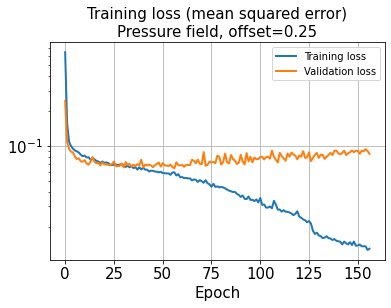

In [71]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nPressure field, offset=0.25', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training loss', 'Validation loss'])
plt.grid()
saveName = case_storage + "\\TrainingLoss_val" + str(val_rate) + "test"+str(test_rate) + "_offset0.25.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

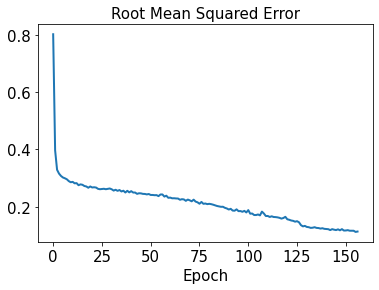

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

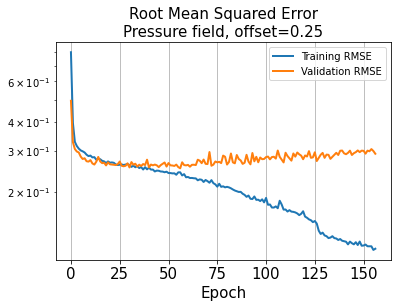

In [72]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nPressure field, offset=0.25', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training RMSE', 'Validation RMSE'])
plt.grid()
saveName = case_storage + "\\RMSE_val" + str(val_rate) + "test"+str(test_rate) + "_offset0.25.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
test_results = model.evaluate(x_test)

7/7 [==============================] - 0s 40ms/step - loss: 2.2515e-05 - rmse: 0.0000e+00


In [44]:
decoded_train_nor = model.predict(x_train)
decoded_val_nor = model.predict(x_val)
decoded_test_nor = model.predict(x_test)

7/7 [==============================] - 0s 27ms/step


In [45]:
decoded_train = decoded_train_nor*np.std(y) + np.mean(y)
decoded_val = decoded_val_nor*np.std(y) + np.mean(y)
decoded_test = decoded_test_nor*np.std(y) + np.mean(y)

In [46]:
os.chdir("D:\\TrainedModels\\20221103")
model_name = "20221103AeroCNN-II_FlowField(Pressure_field)_offset0.25_val" + str(val_rate) + "test"+str(test_rate)+".h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_val_abs = np.abs(decoded_val - y_val)

In [49]:
error_test_abs = np.abs(decoded_test - y_test)

In [50]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.2187069073277648


In [51]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.2427028341261494


In [52]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.2670746286029631


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

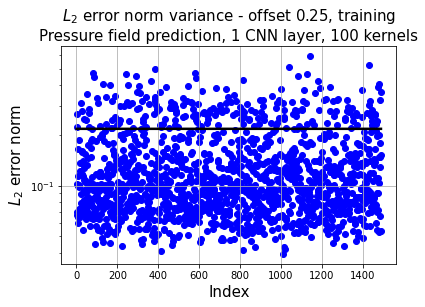

In [73]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - offset 0.25, training\nPressure field prediction, 1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
saveName = case_storage + "\\trainingErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

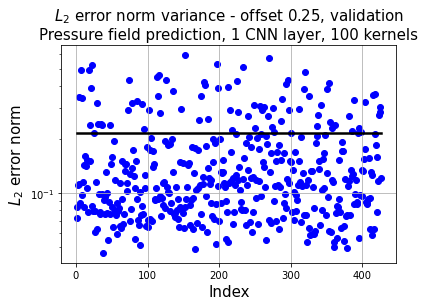

In [74]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_train*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - offset 0.25, validation\nPressure field prediction, 1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
saveName = case_storage + "\\validationErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

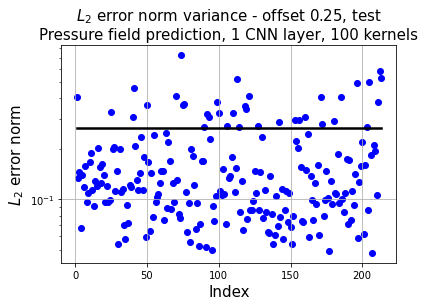

In [75]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - offset 0.25, test\nPressure field prediction, 1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
saveName = case_storage + "\\testErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [59]:
os.chdir("D:\\20221103aeroCNNII(-1to1)\\offset0.25_validation0.2test0.1\\PressureField")

In [60]:
xrange = np.linspace(-1, 1, n_grid)
yrange = np.linspace(-1, 1, n_grid)
xmesh, ymesh = np.meshgrid(xrange, yrange)

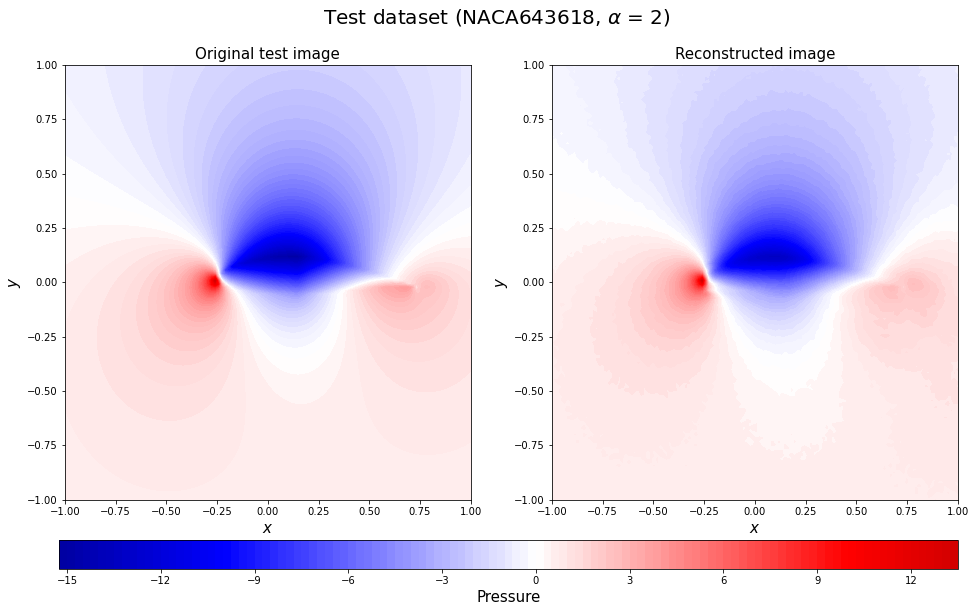

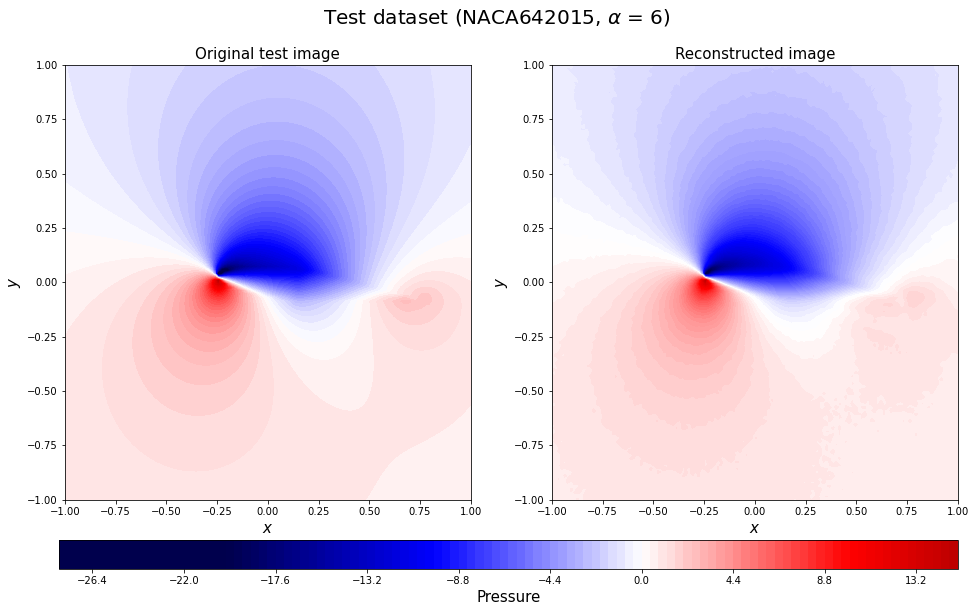

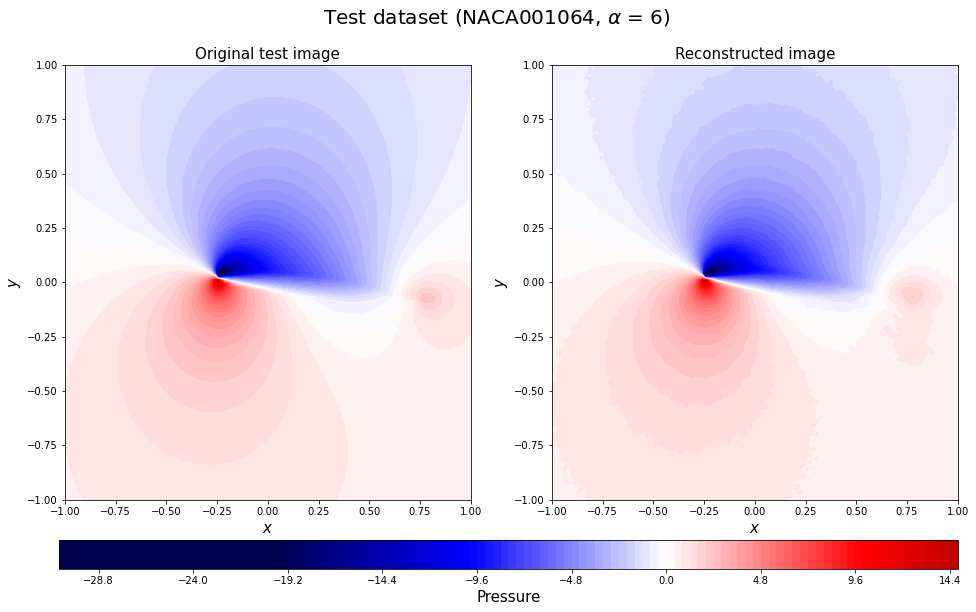

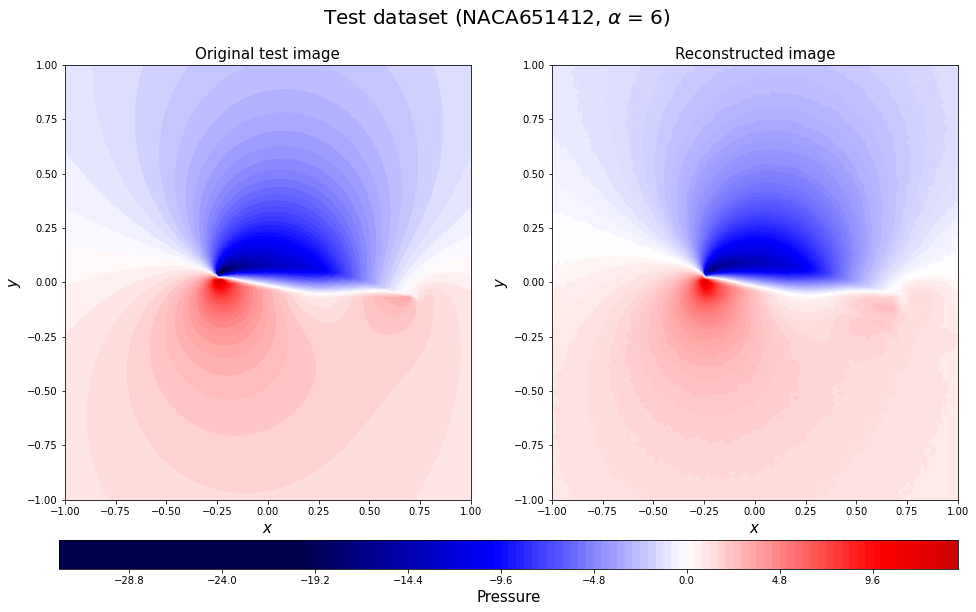

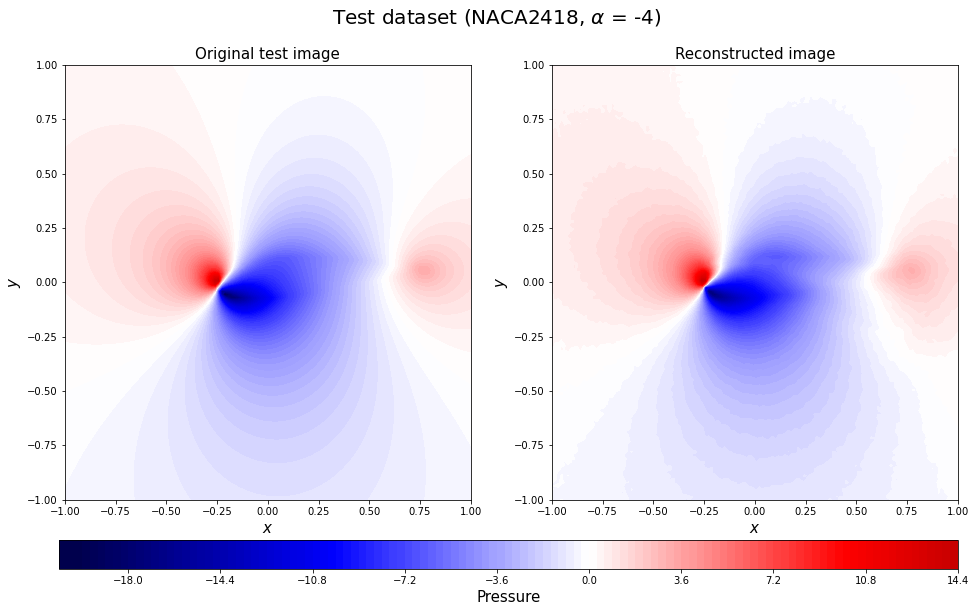

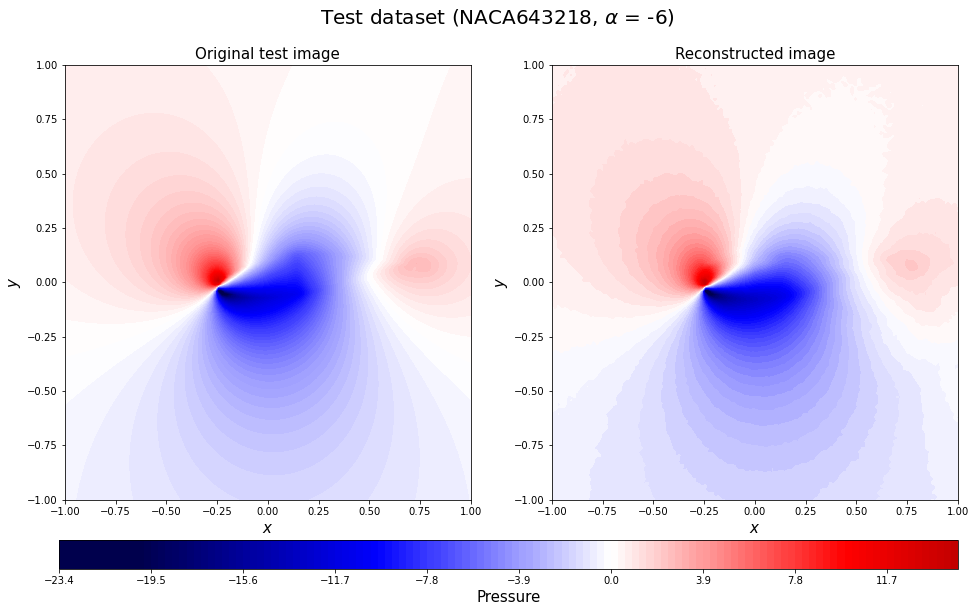

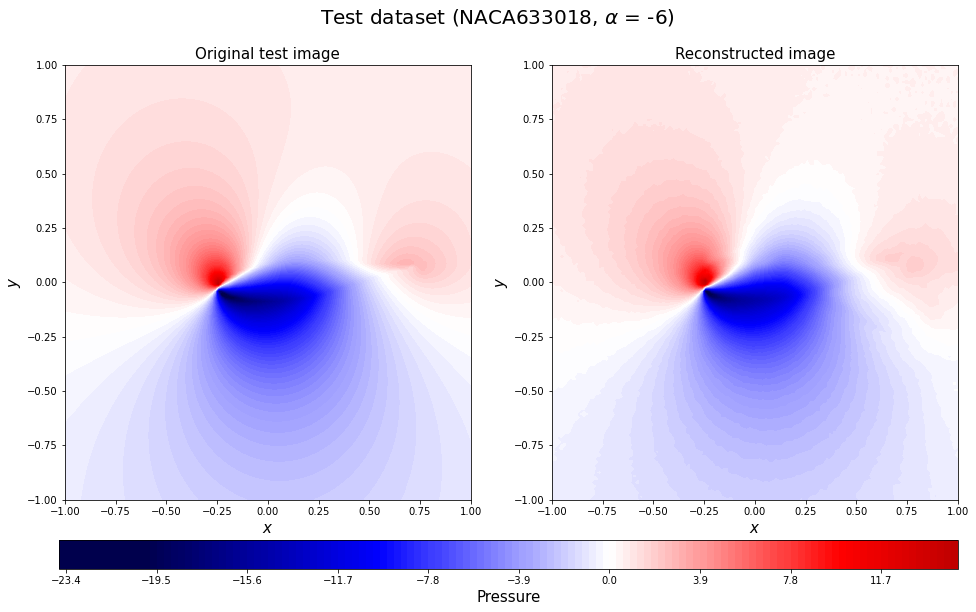

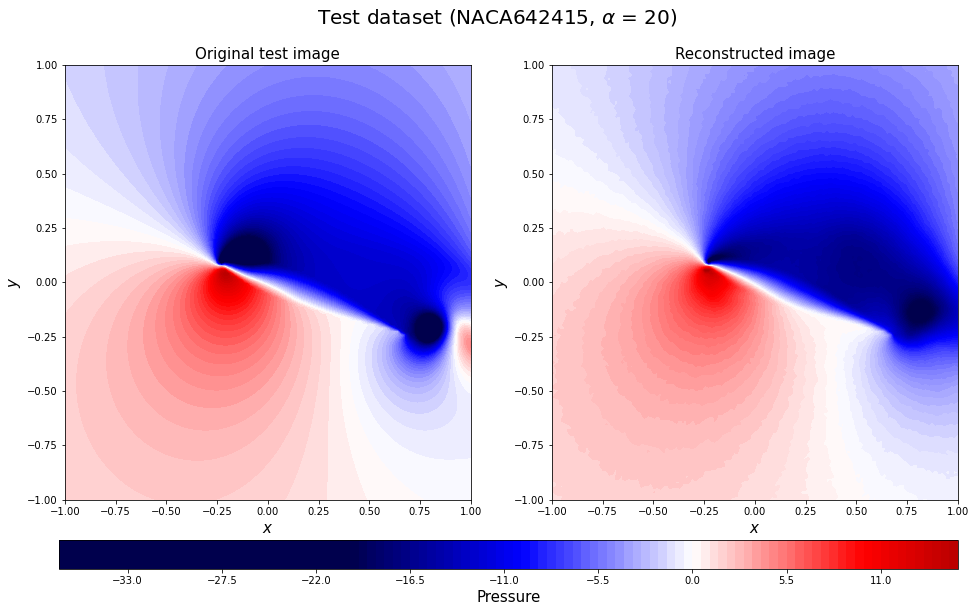

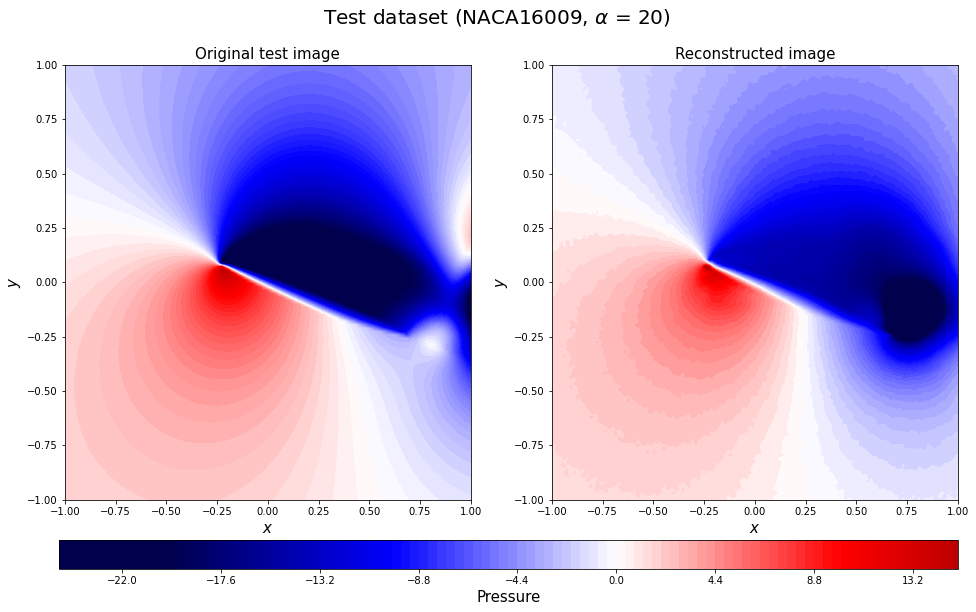

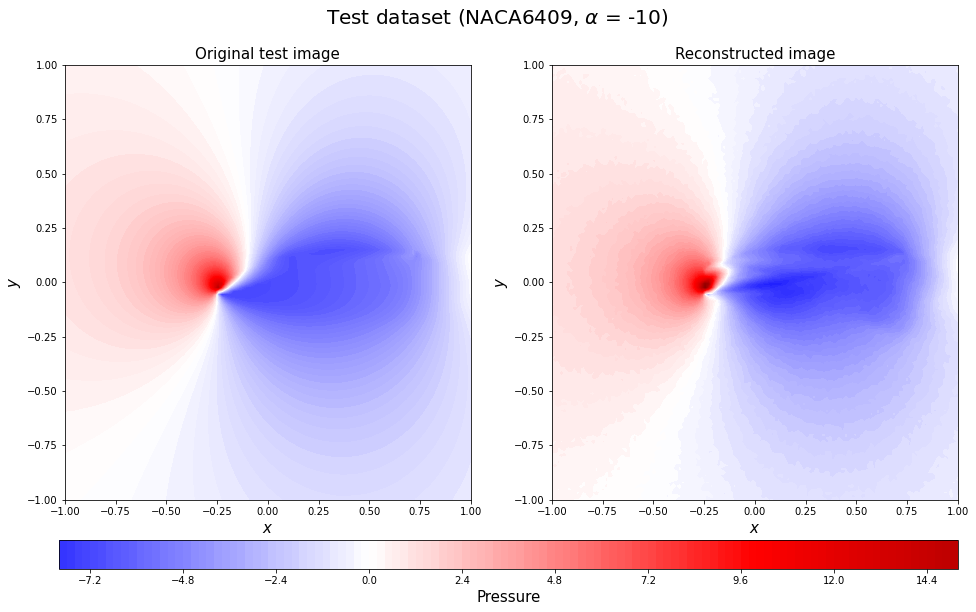

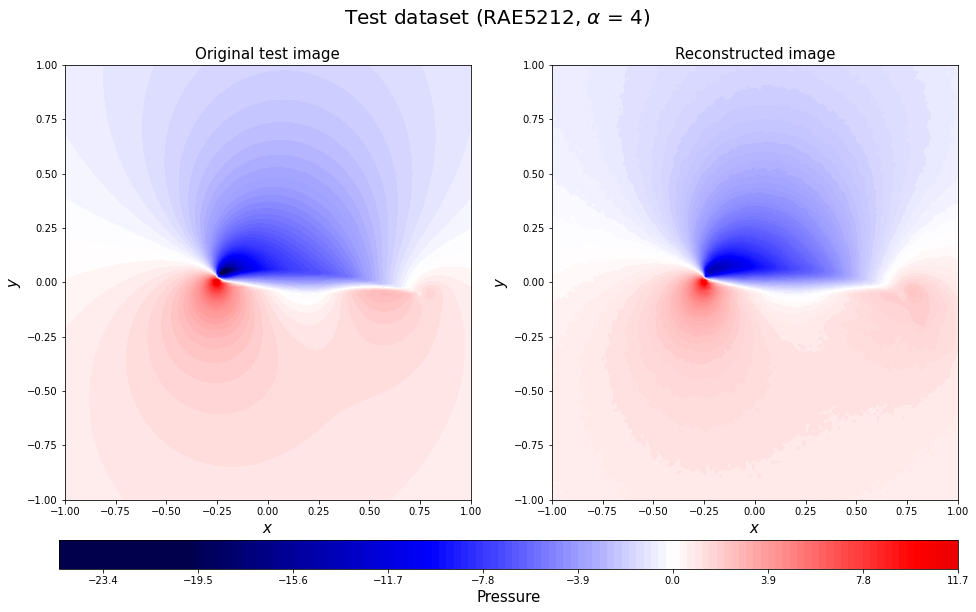

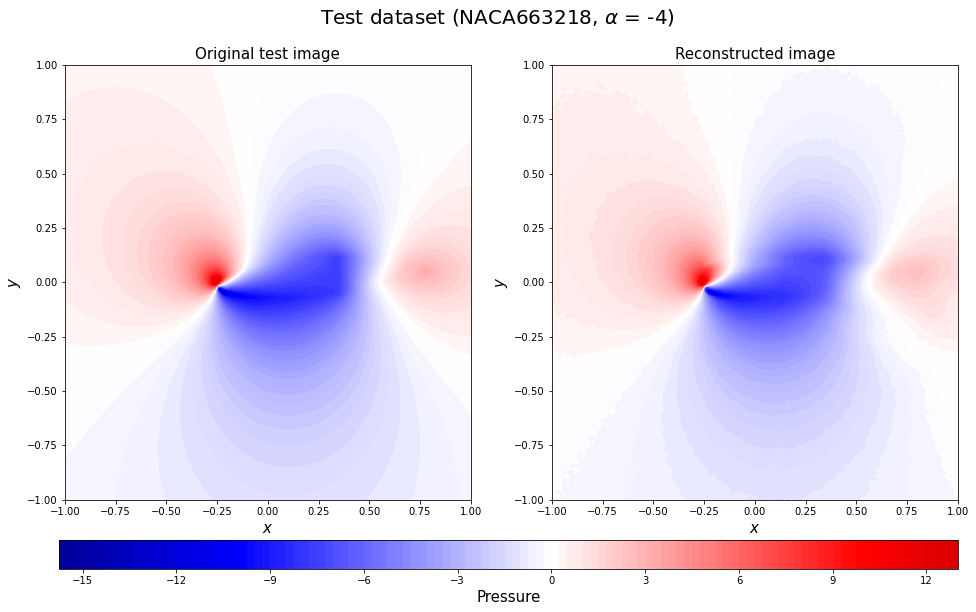

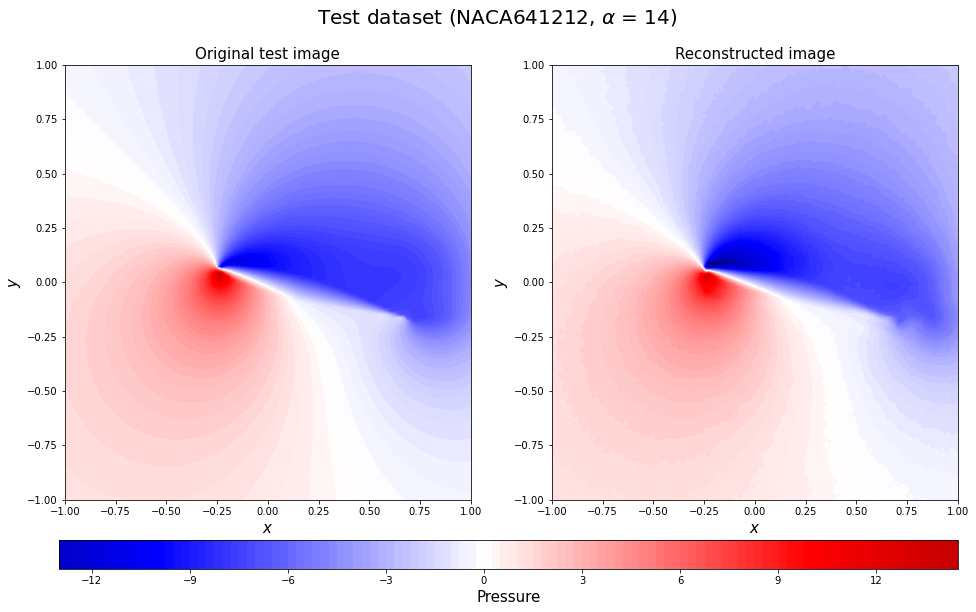

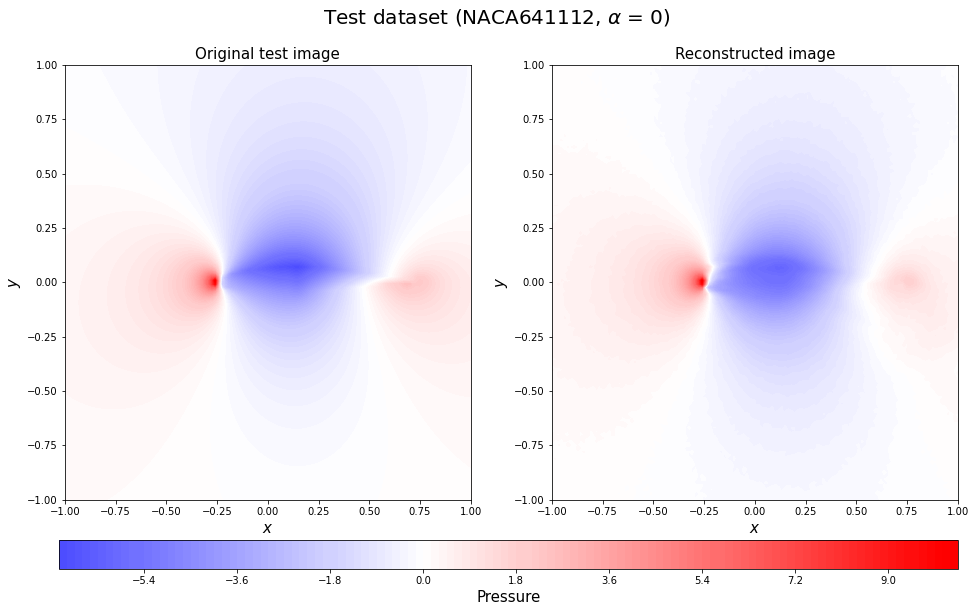

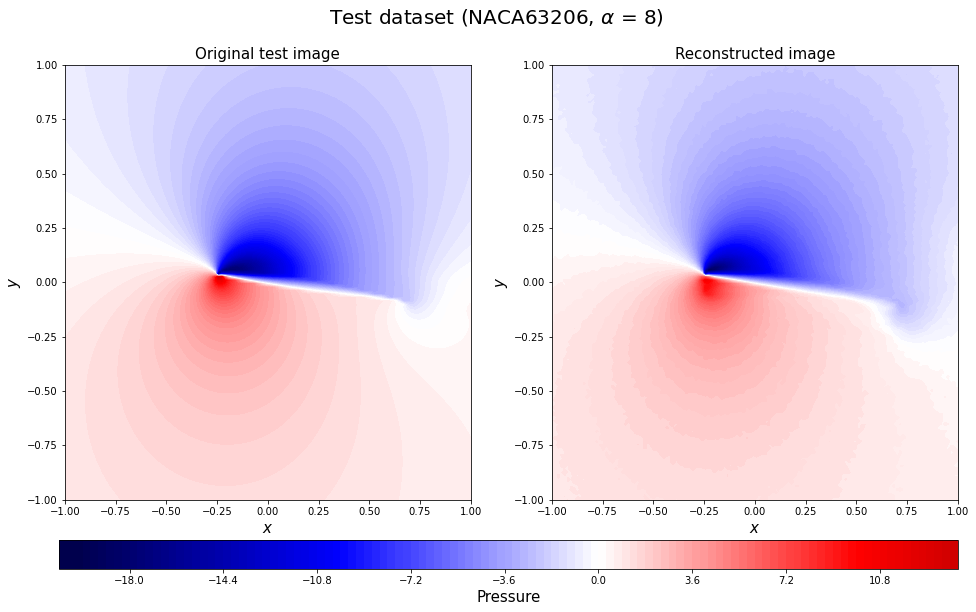

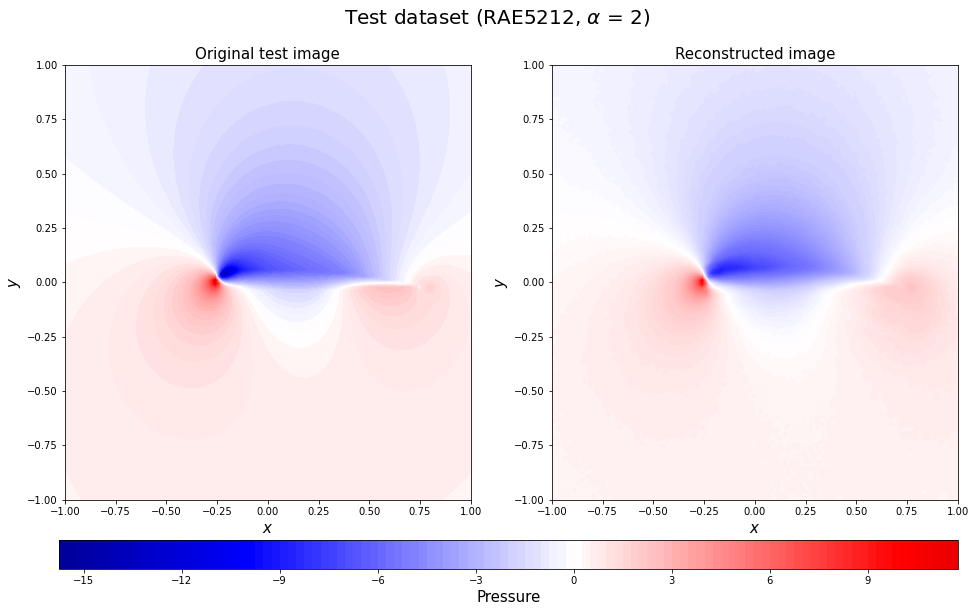

In [62]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*16+c].reshape(n_grid,n_grid)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=-20, vmax=20, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=-20, vmax=20,  levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Pressure', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*16+c])[3:-2], aa_test[2*16+c]),fontsize=20)
    save_fig_name = "20221107Prediction_AeroCNN-II(test)"+str(np.array2string(geo_test[2*16+c])[3:-2])+str(aa_test[2*16+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

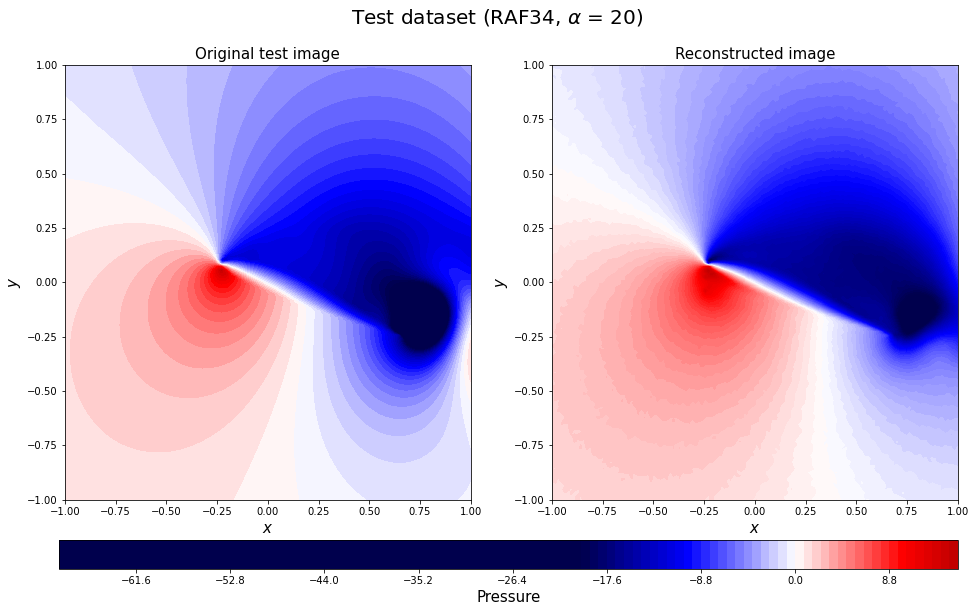

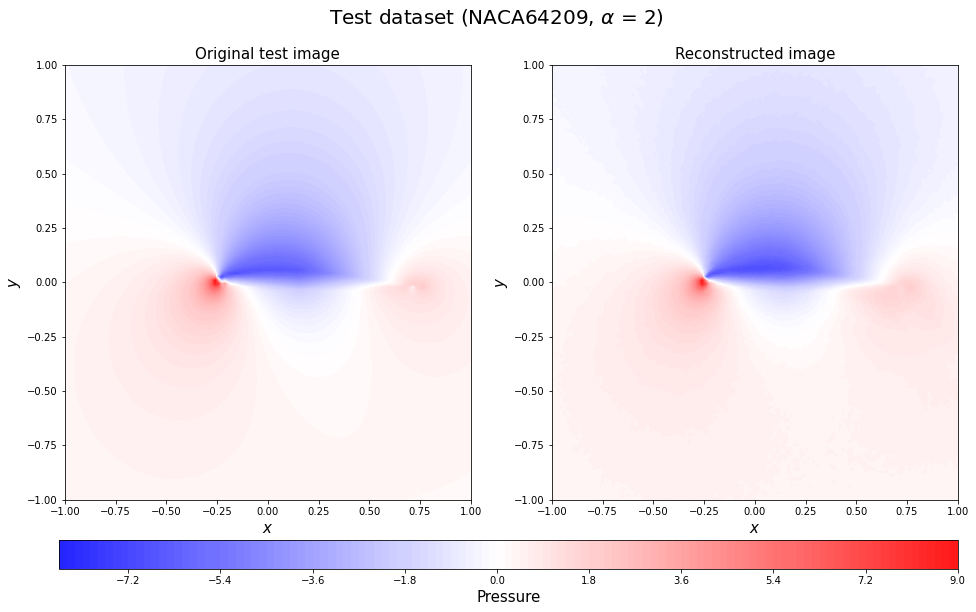

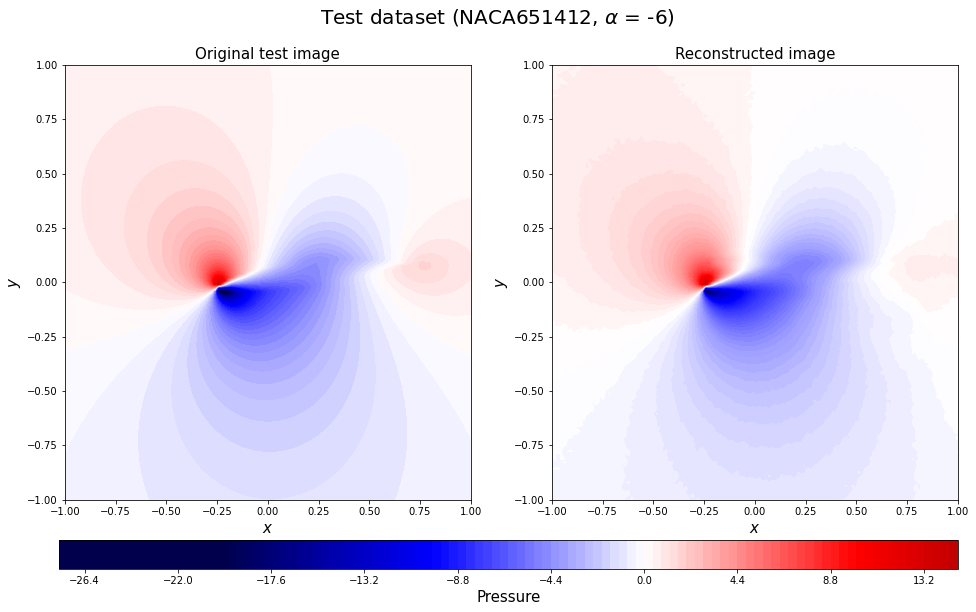

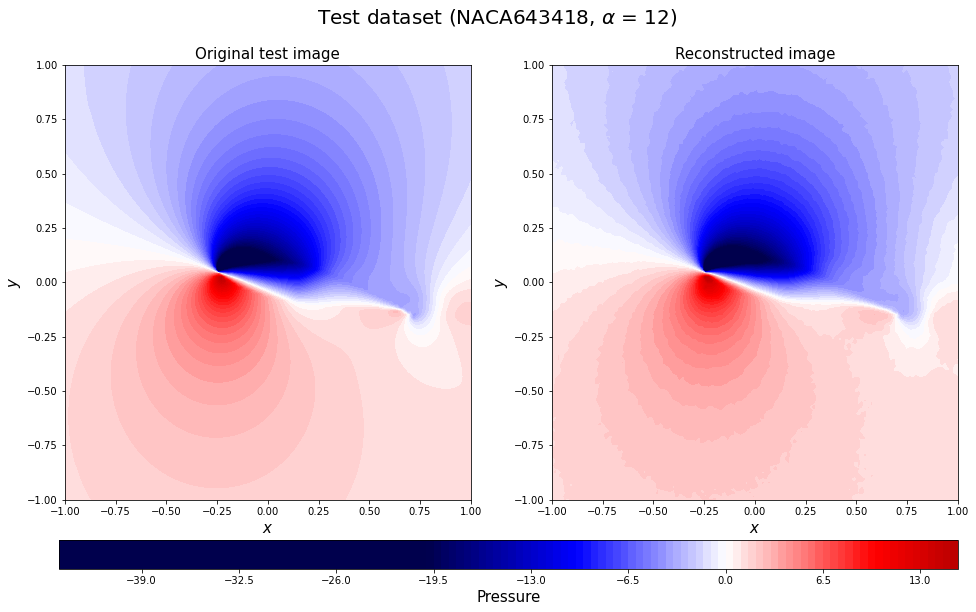

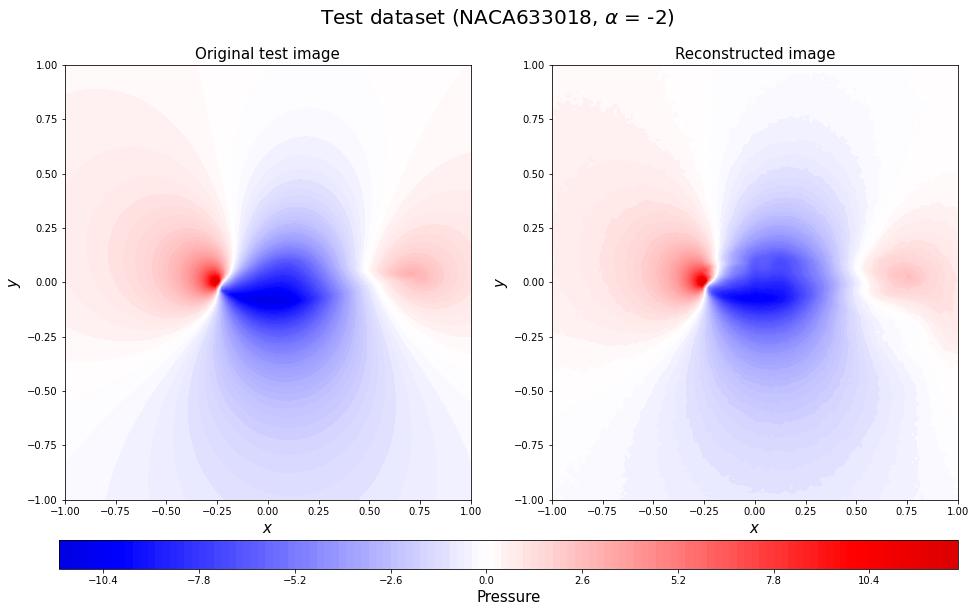

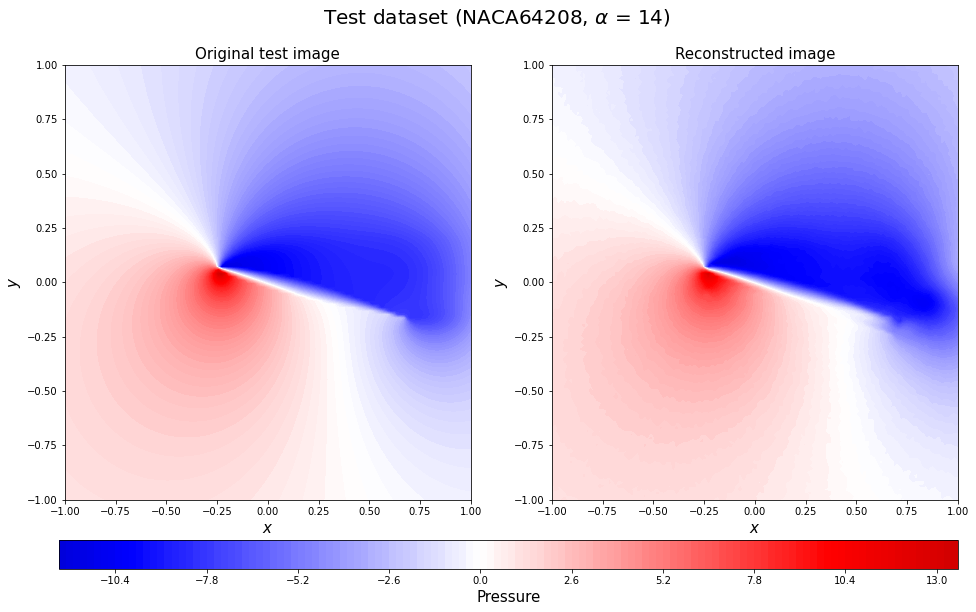

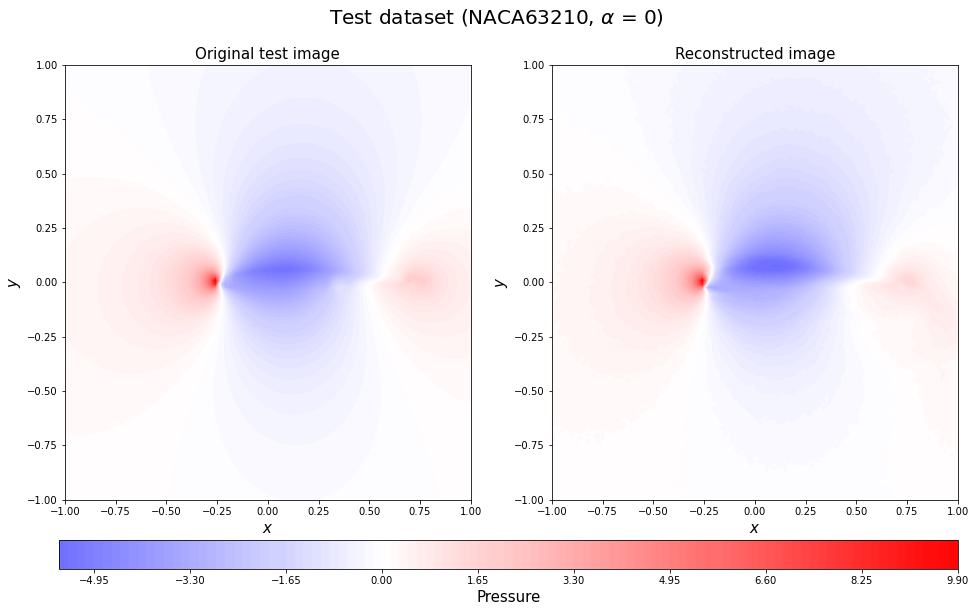

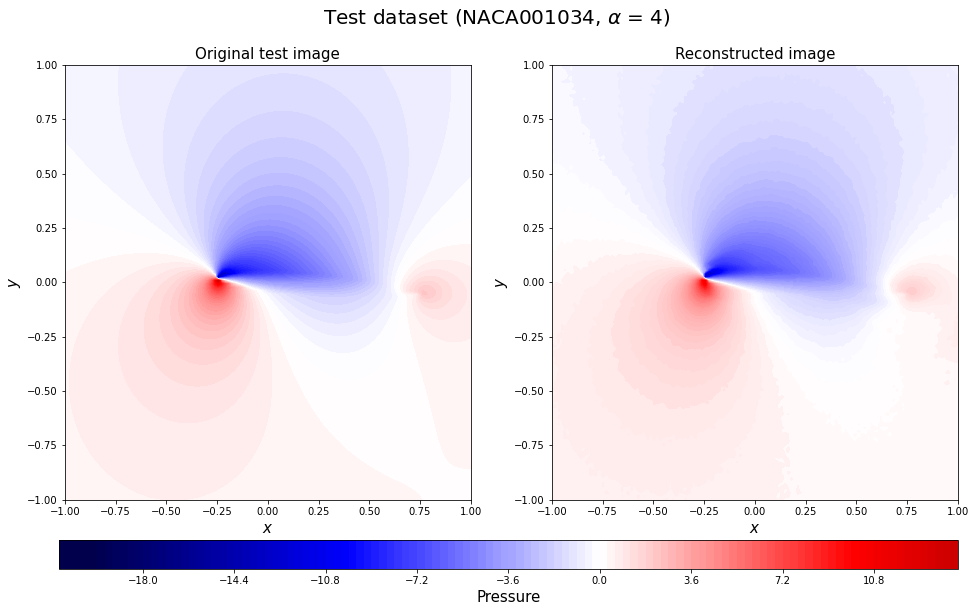

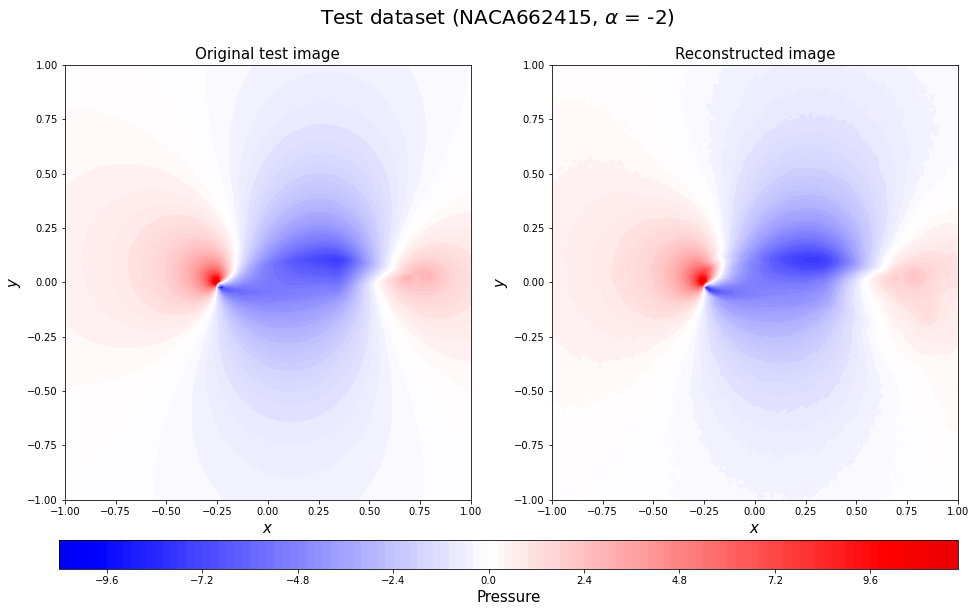

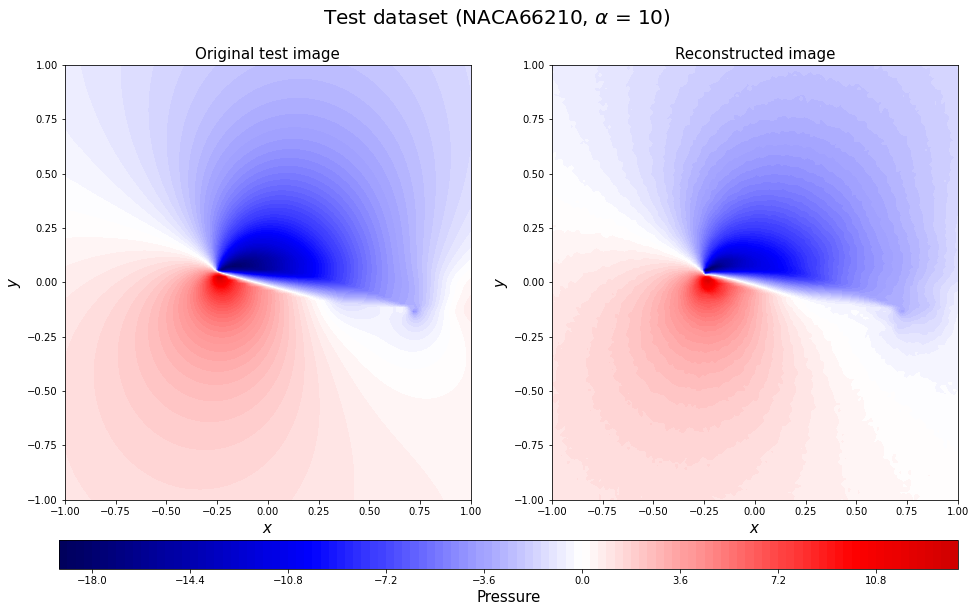

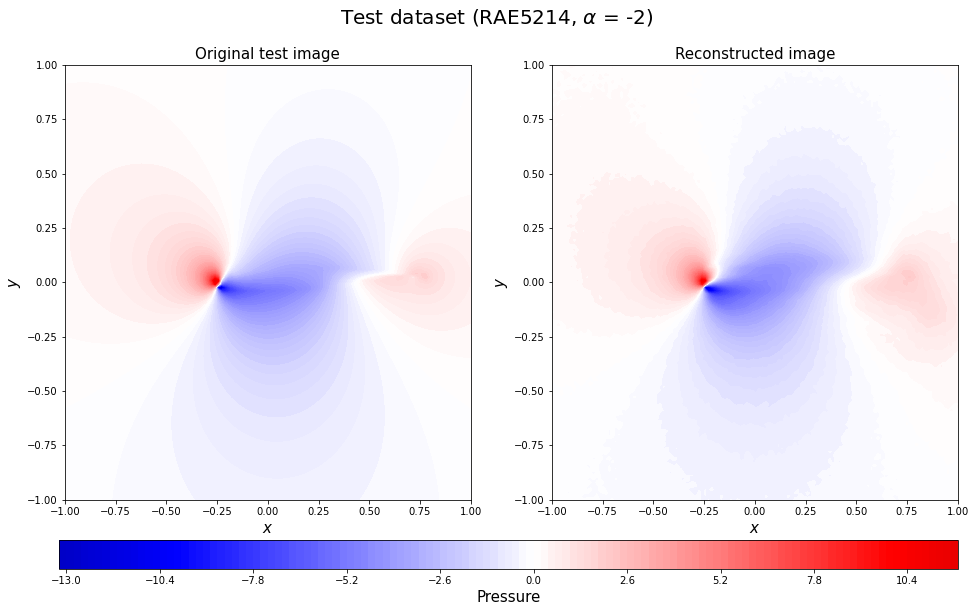

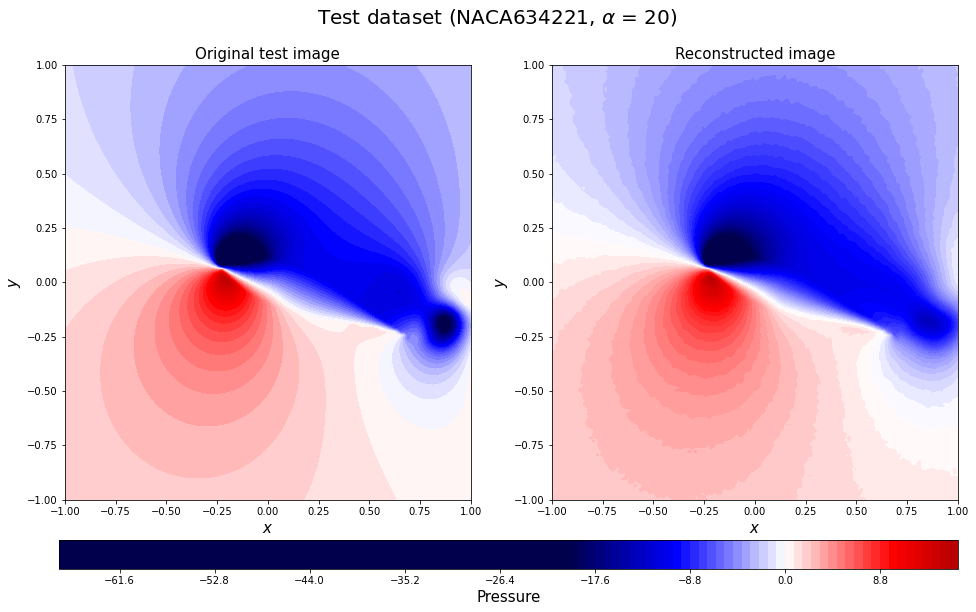

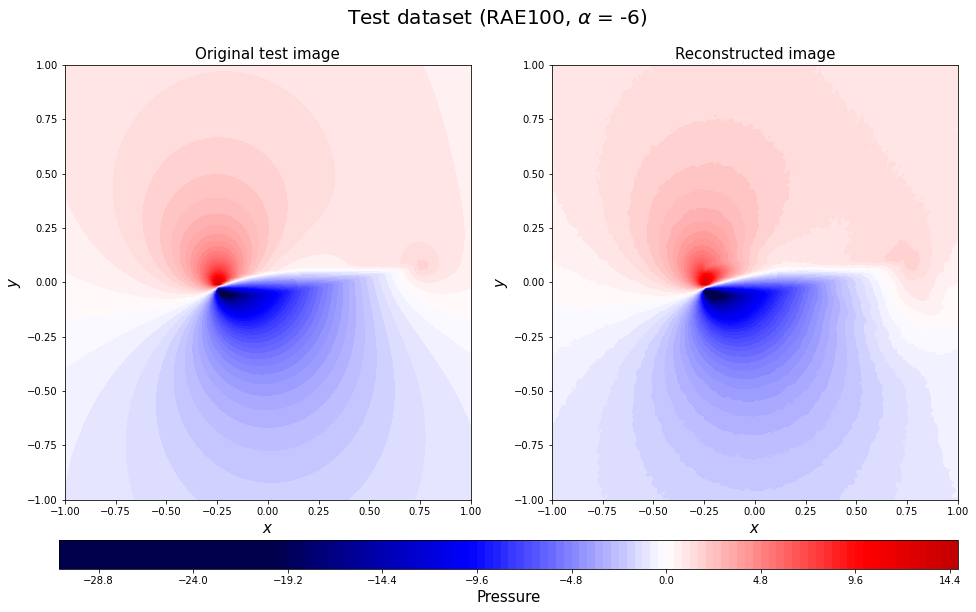

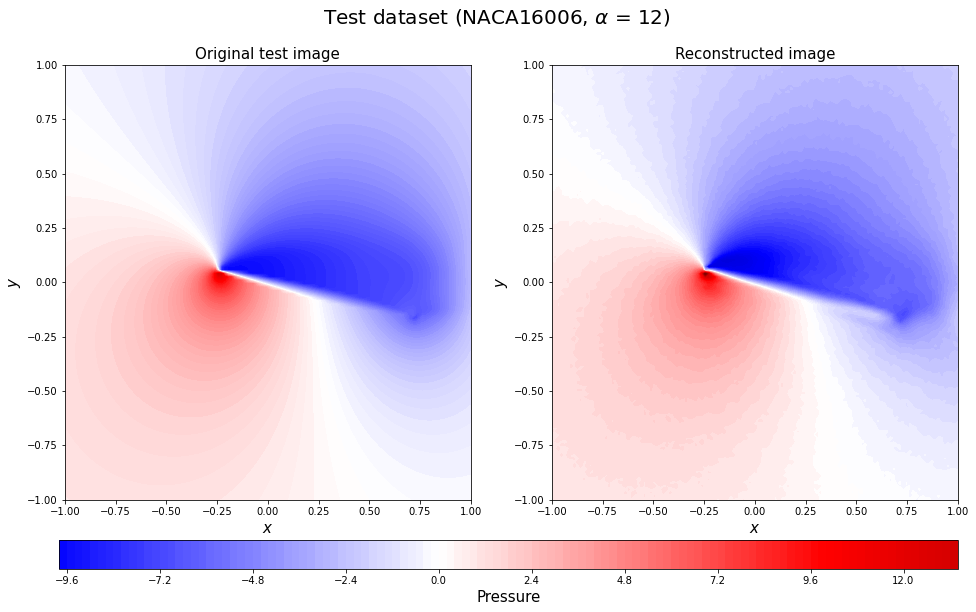

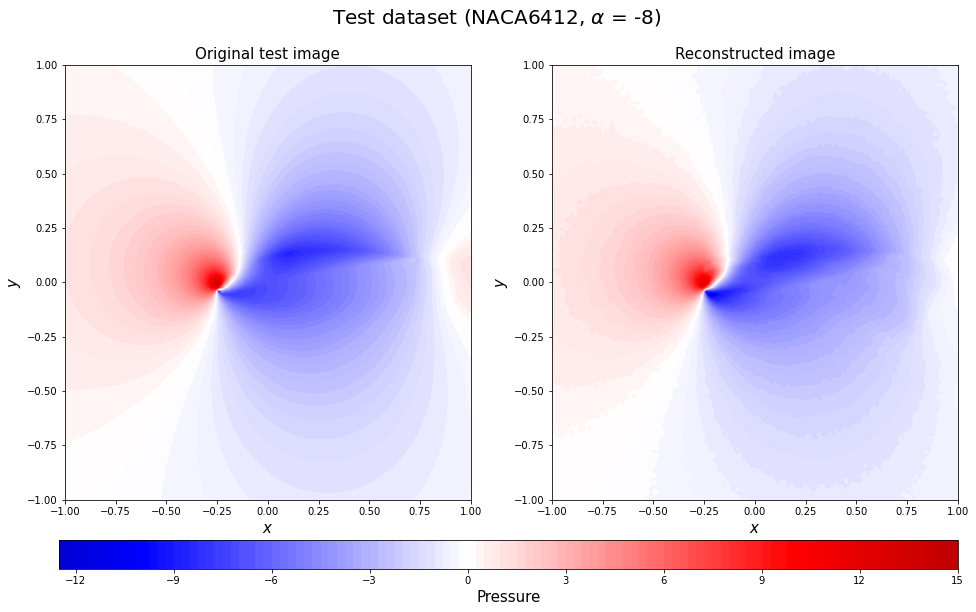

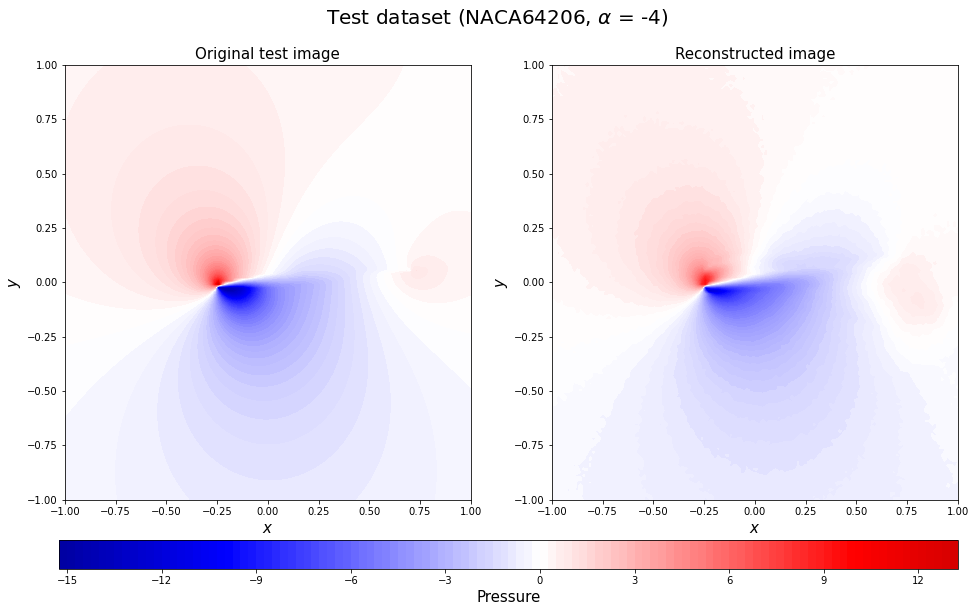

In [63]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=-20, vmax=20, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=-20, vmax=20, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Pressure', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    save_fig_name = "20221107Prediction_AeroCNN-II(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

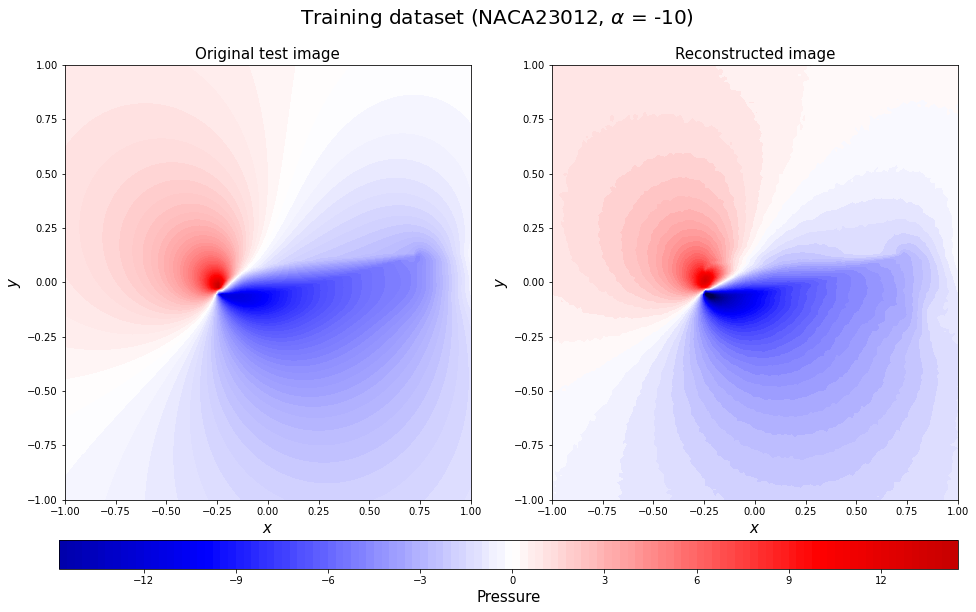

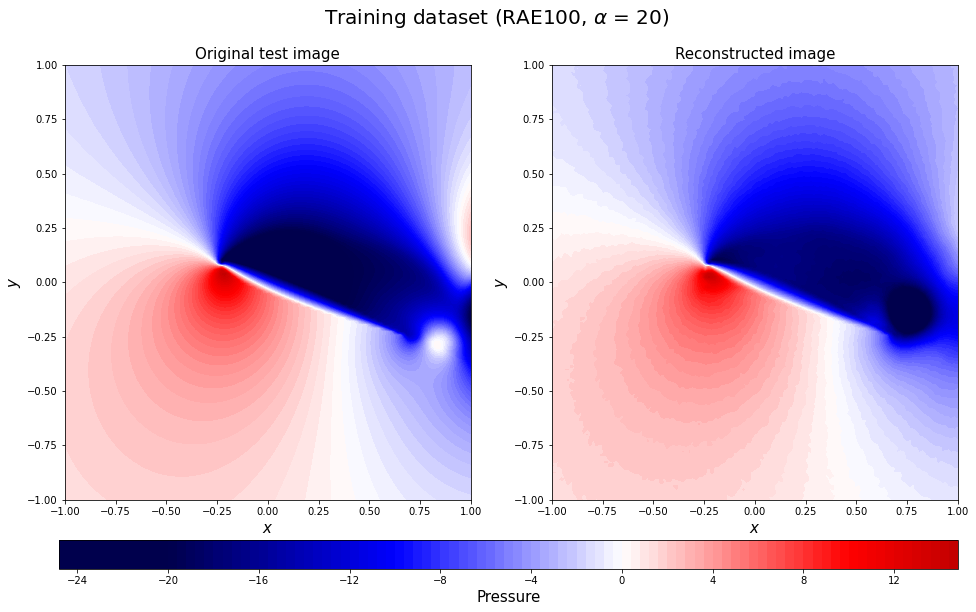

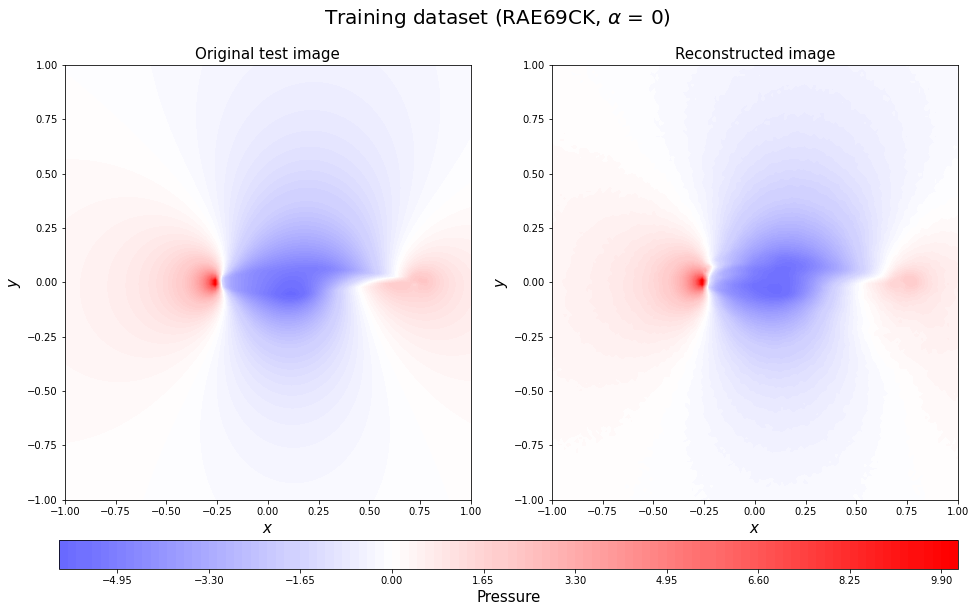

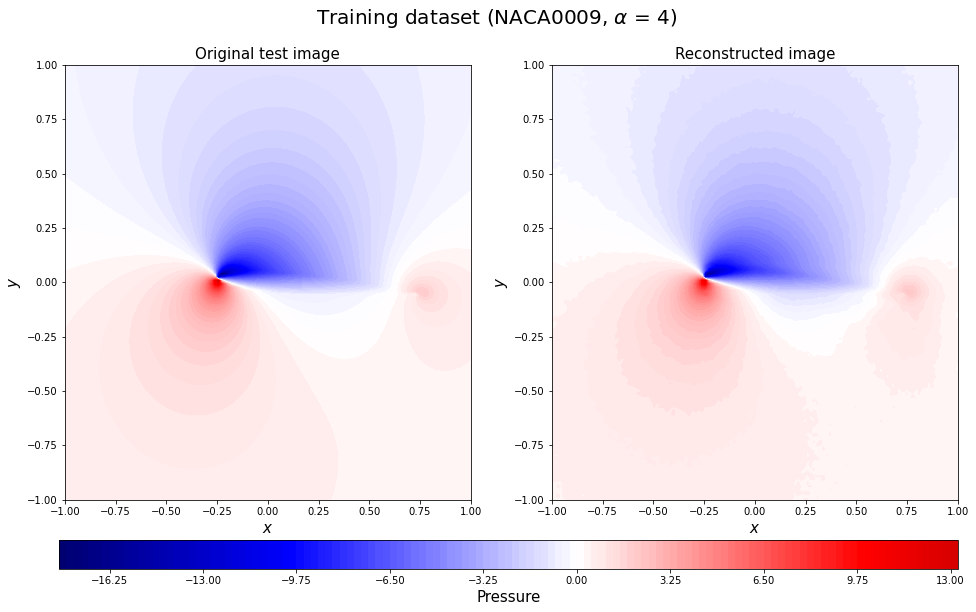

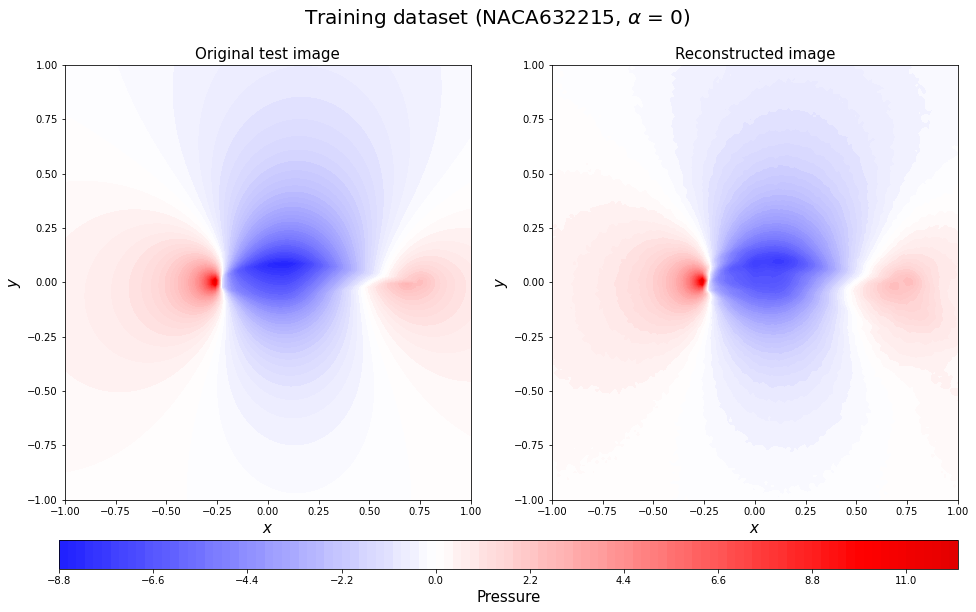

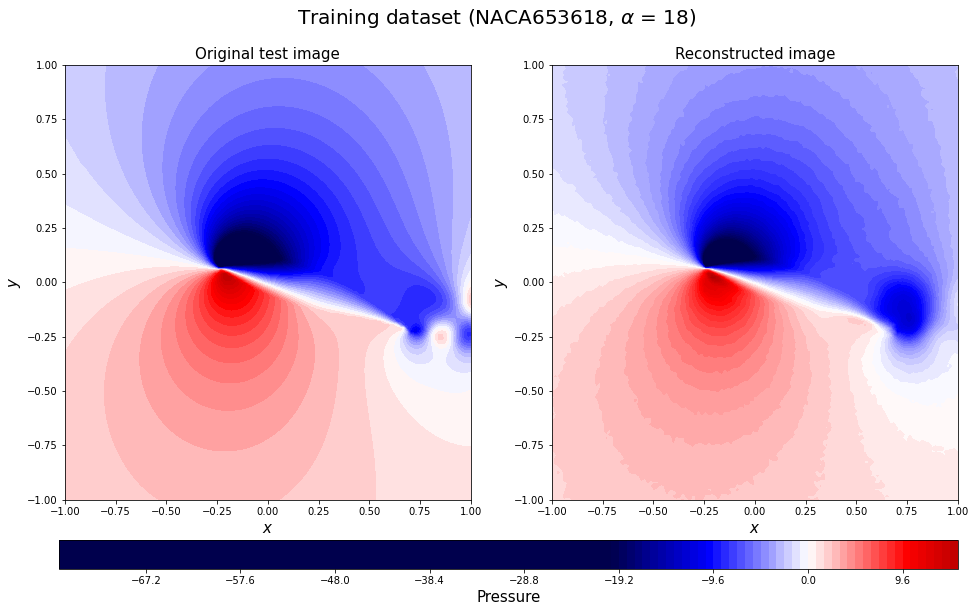

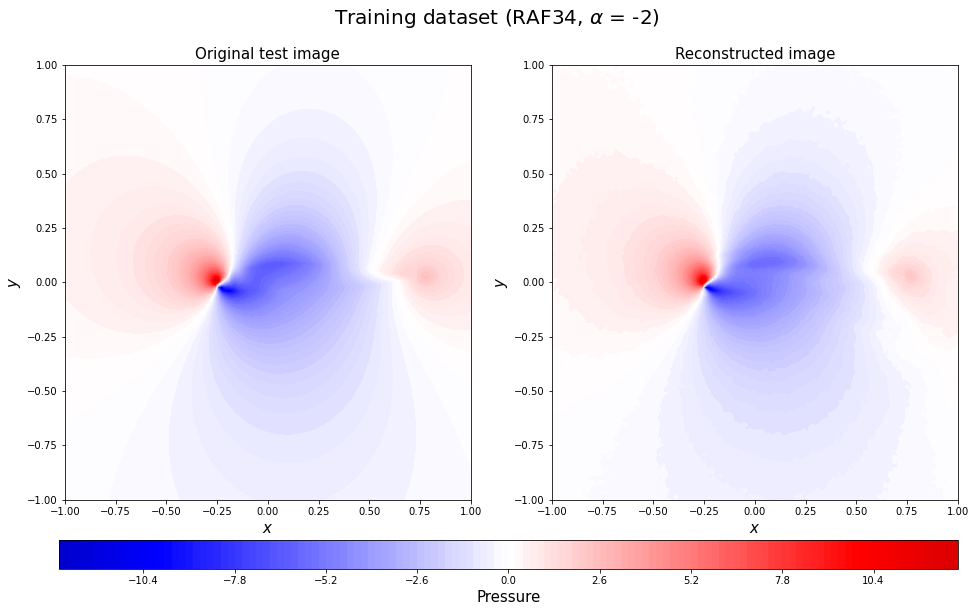

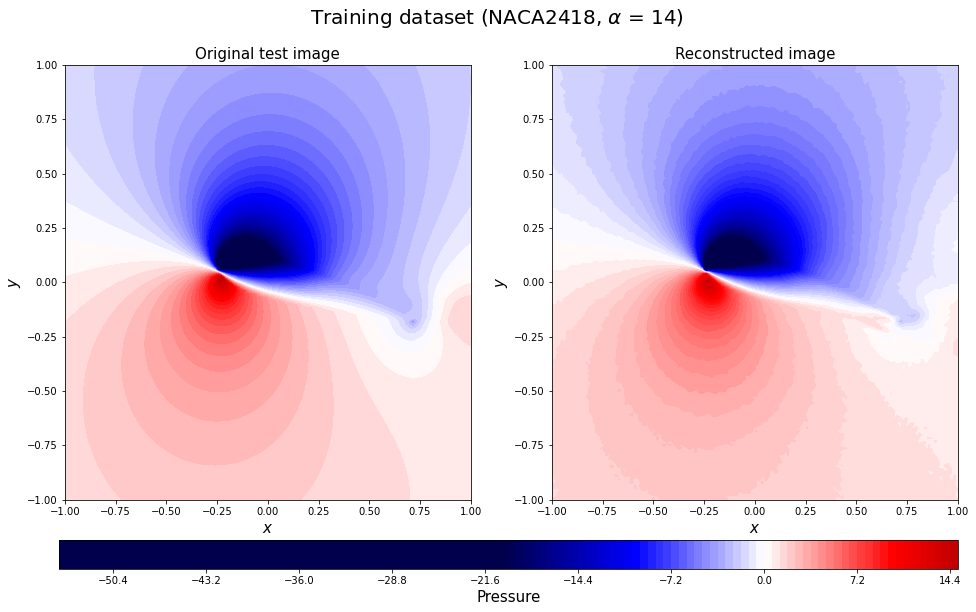

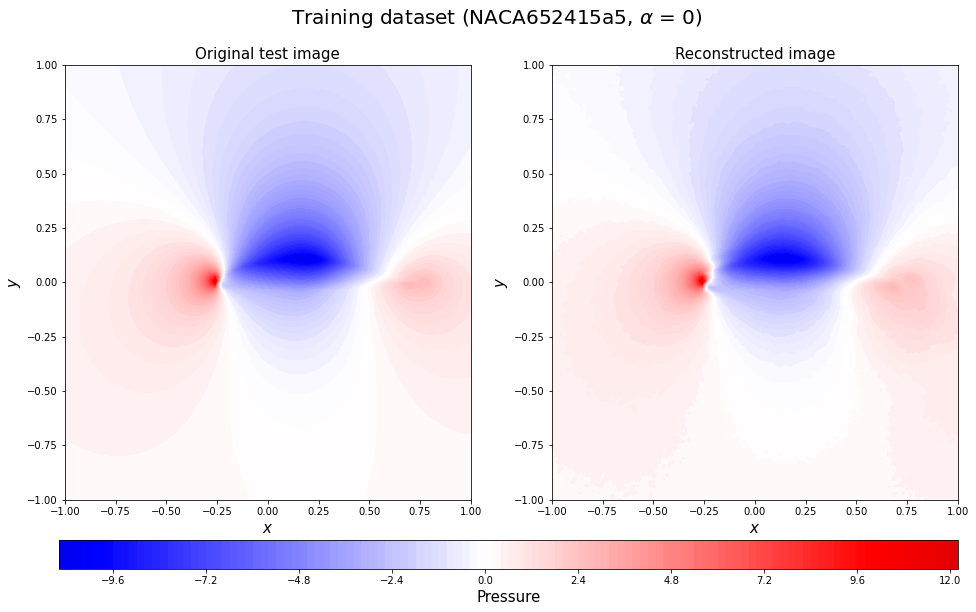

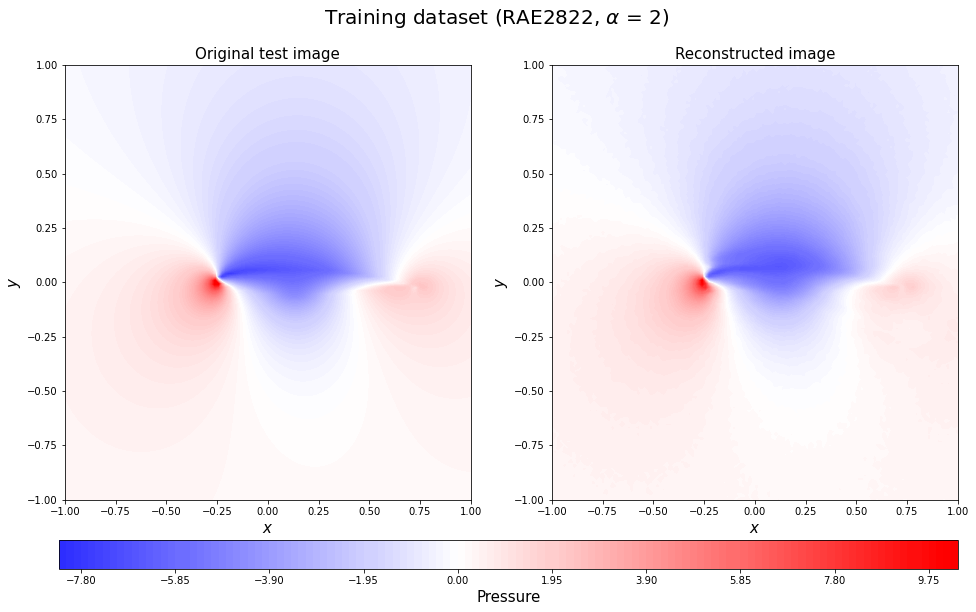

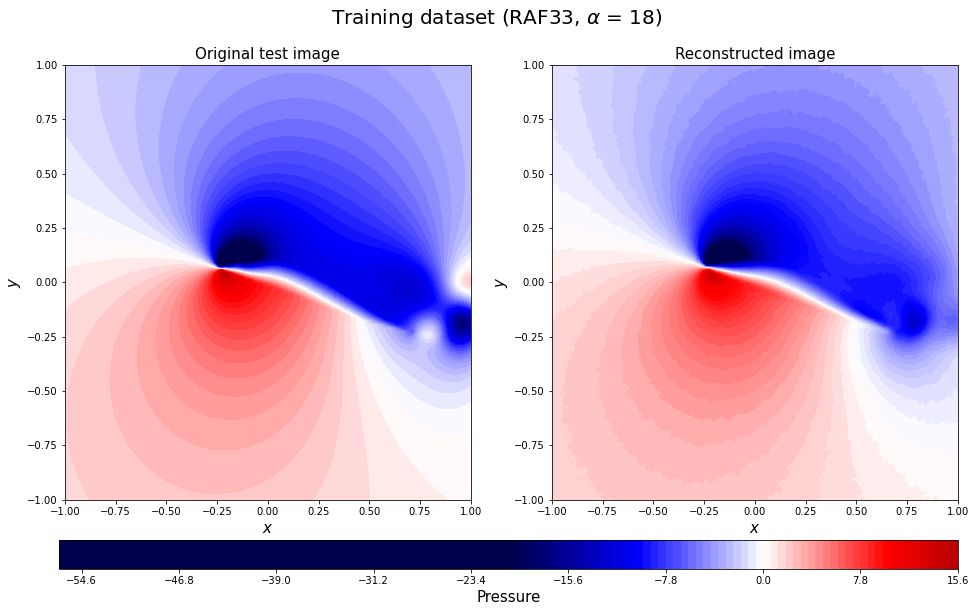

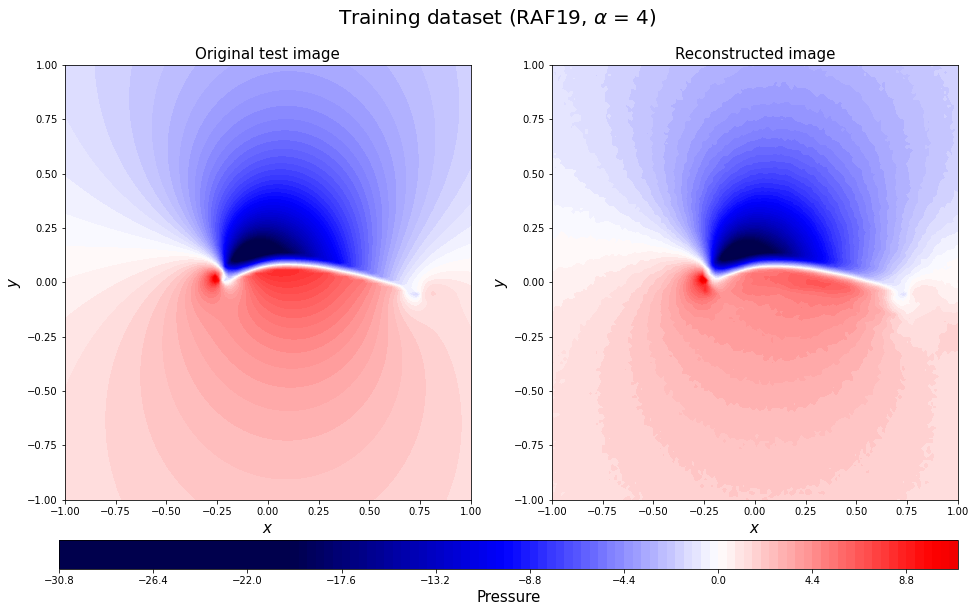

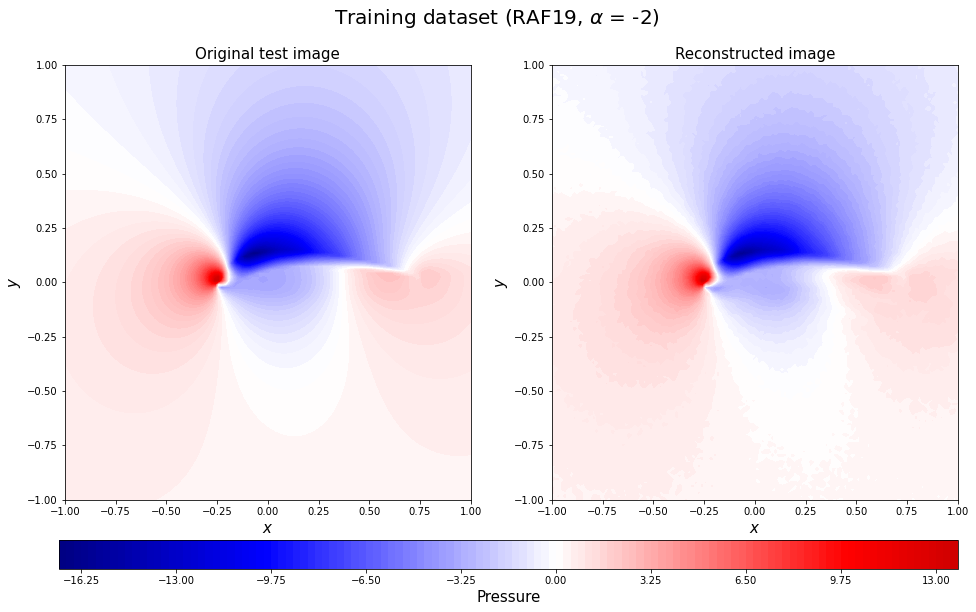

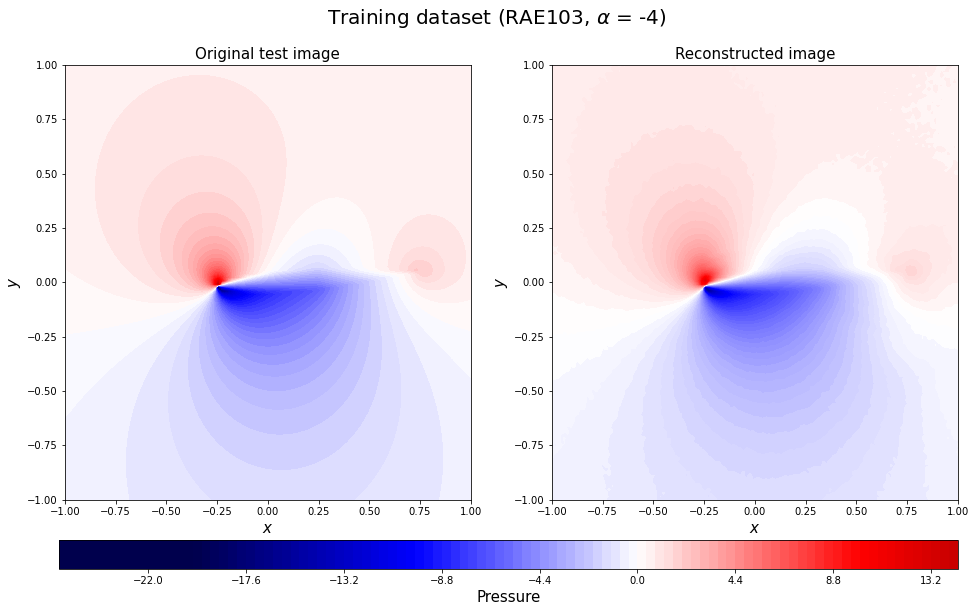

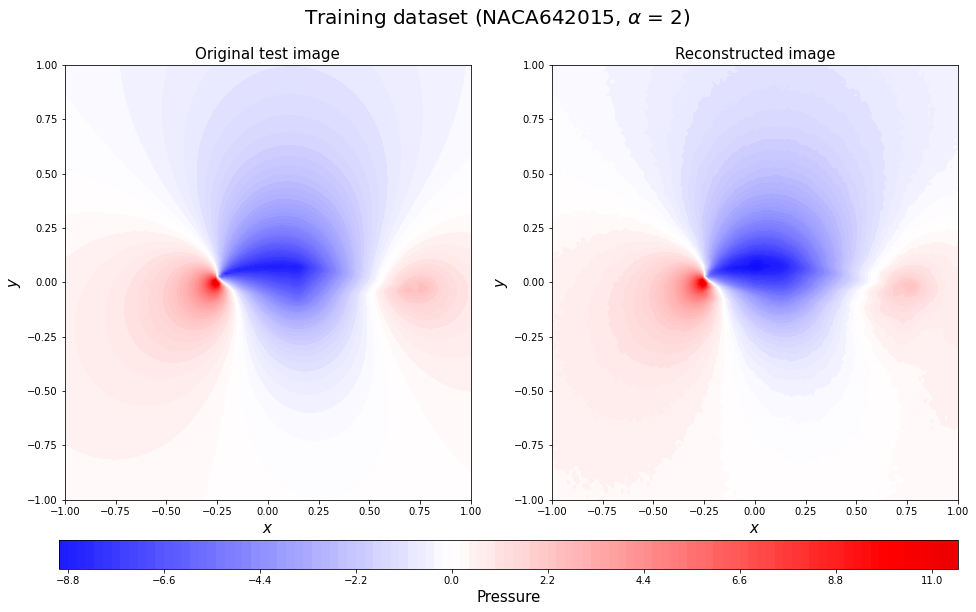

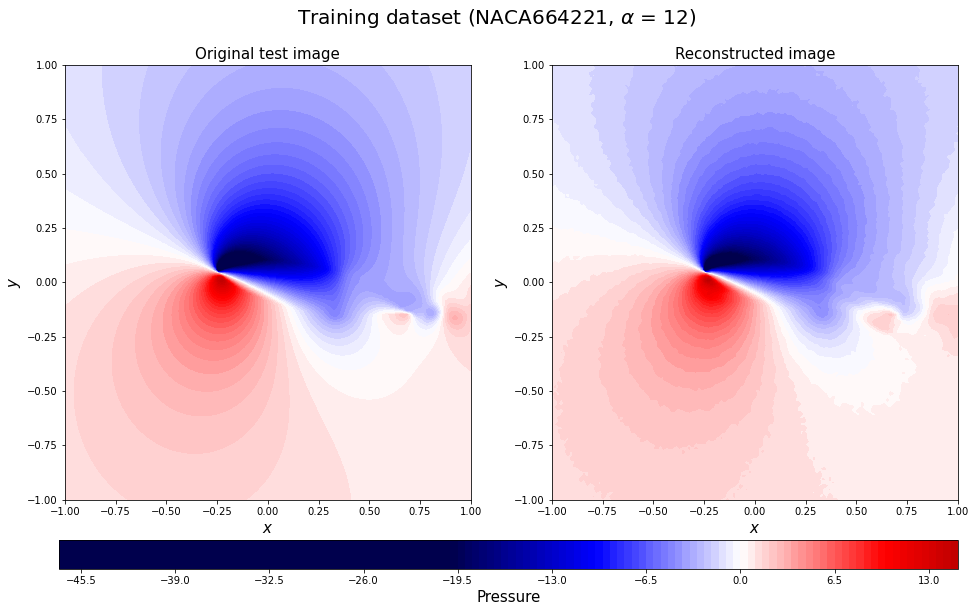

In [64]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=-20, vmax=20, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=-20, vmax=20,  levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Pressure', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    save_fig_name = "20221107Prediction_AeroCNN-II(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

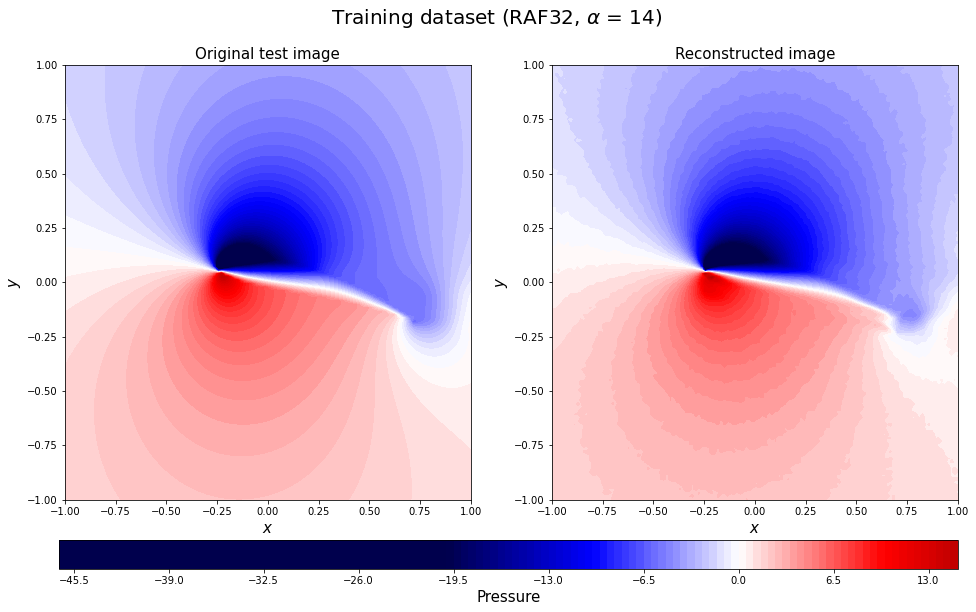

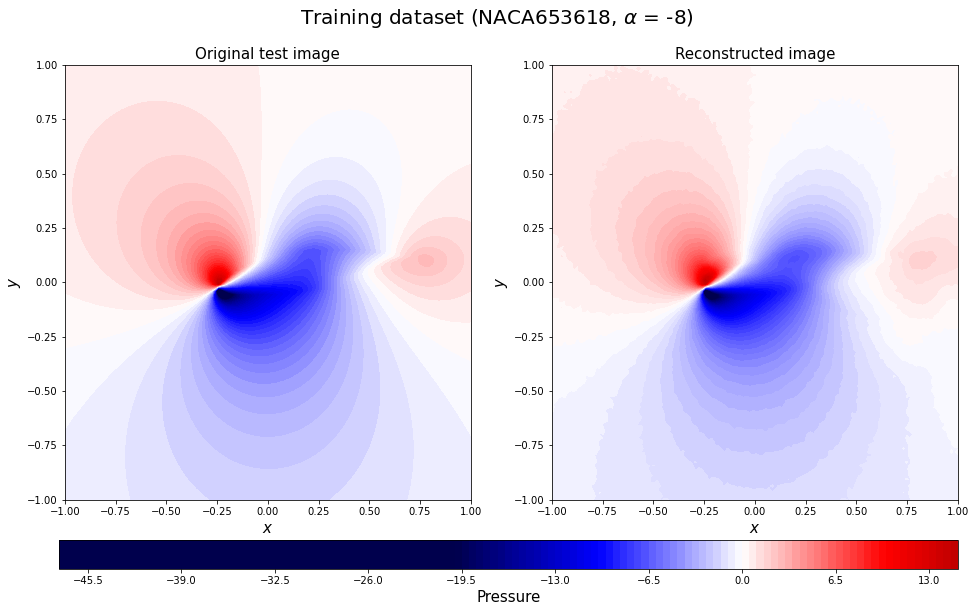

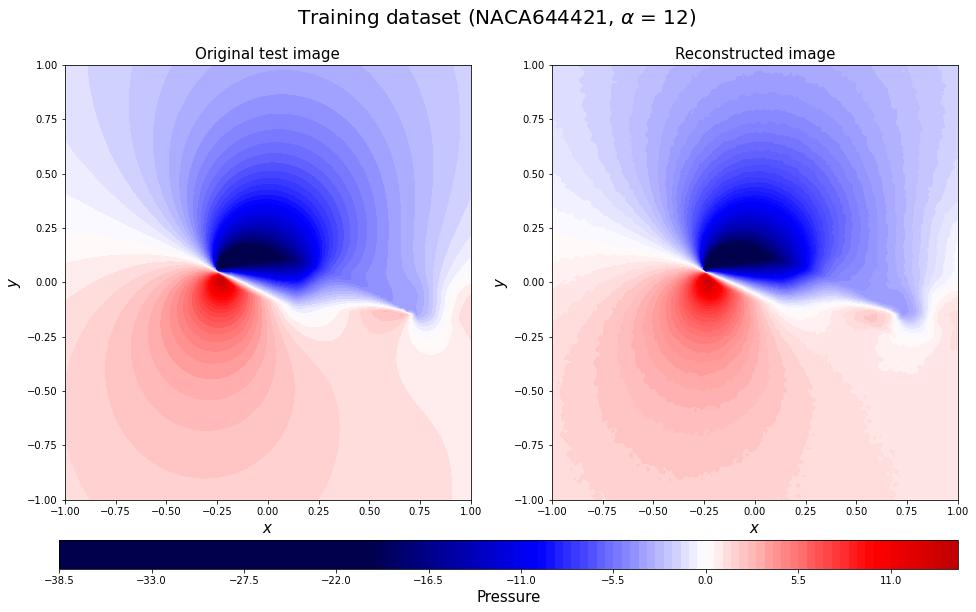

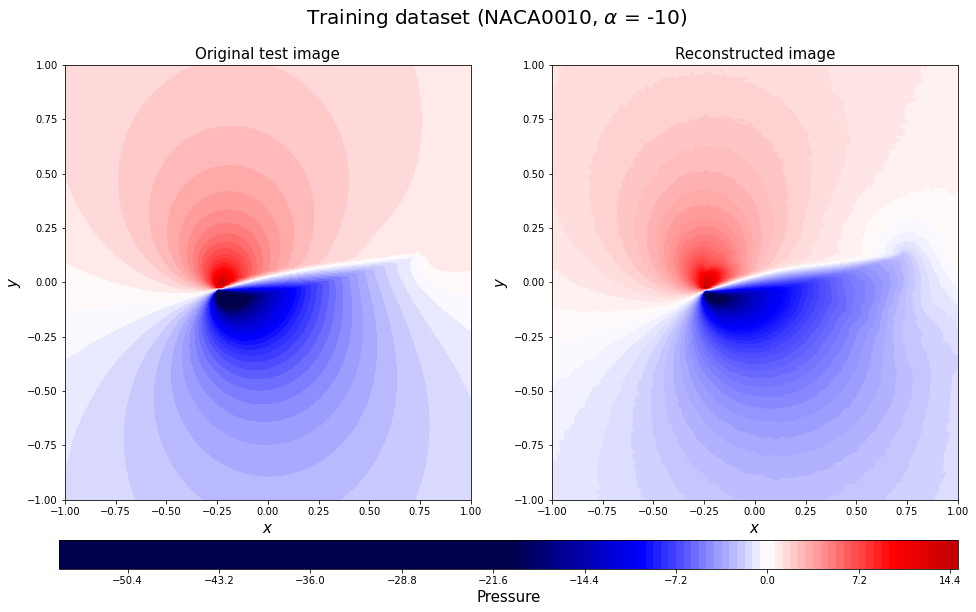

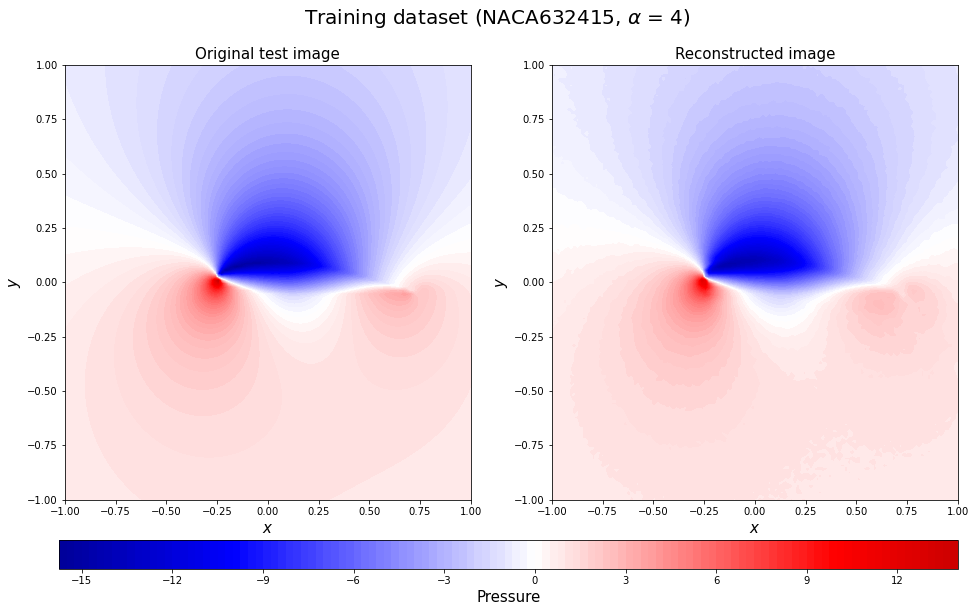

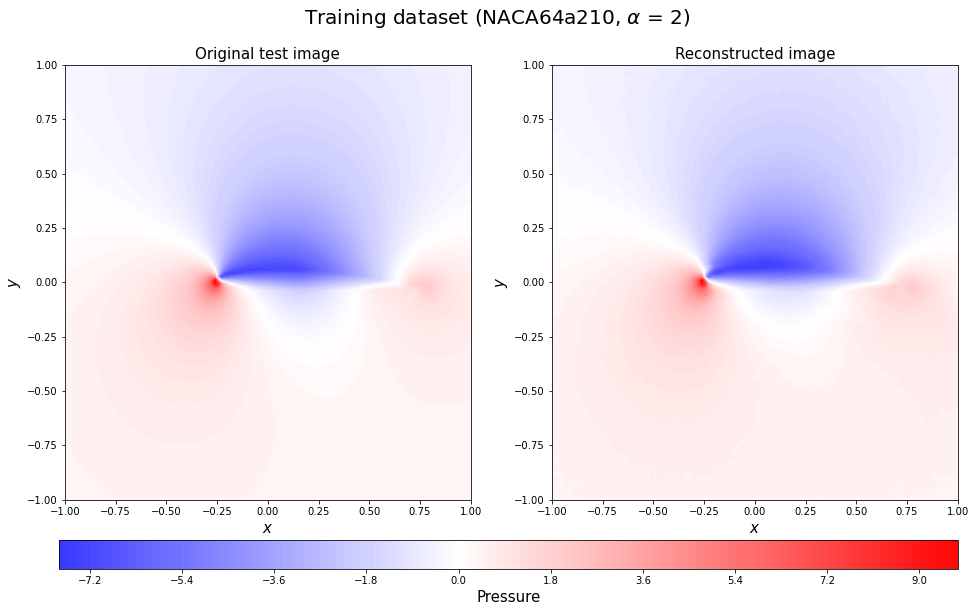

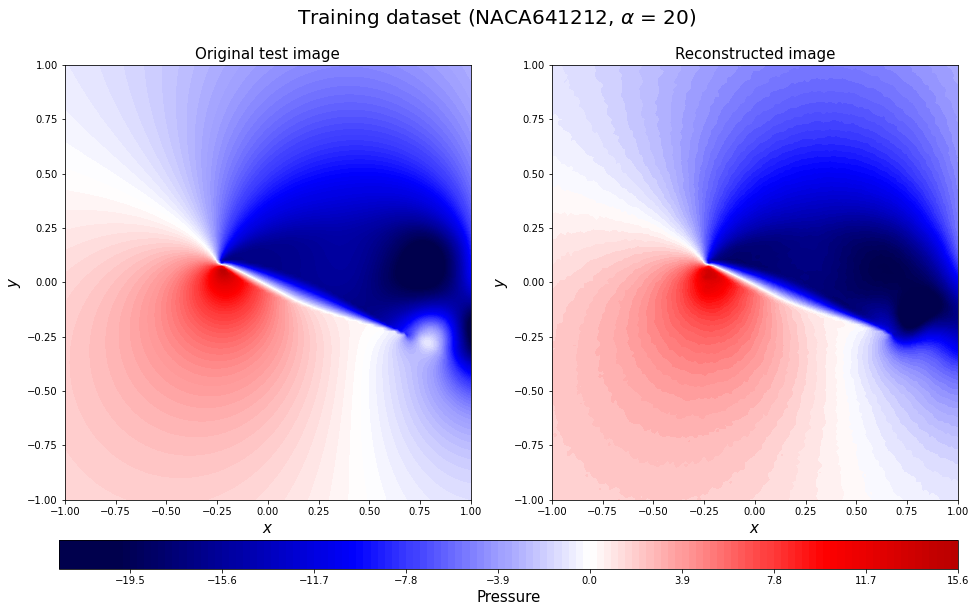

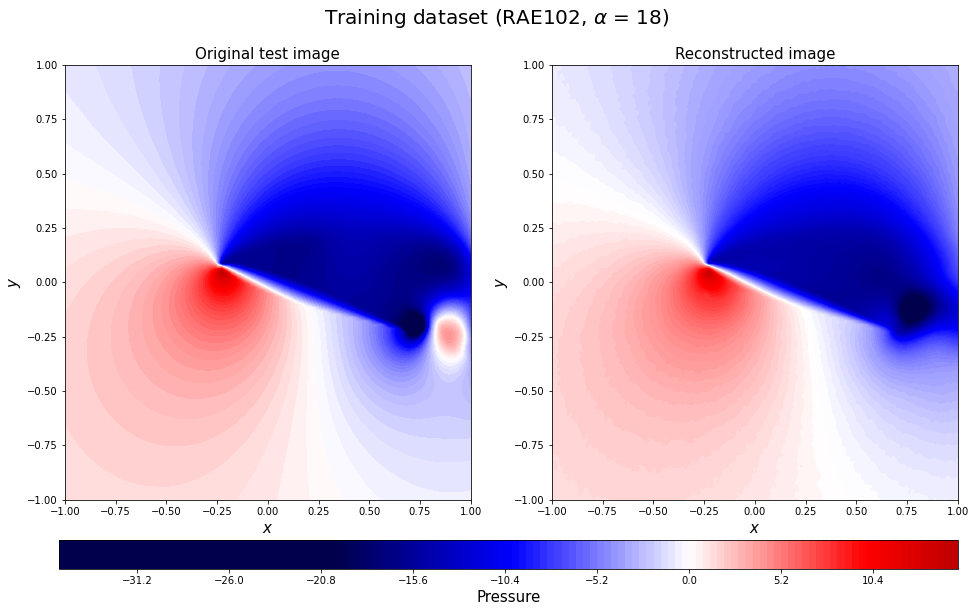

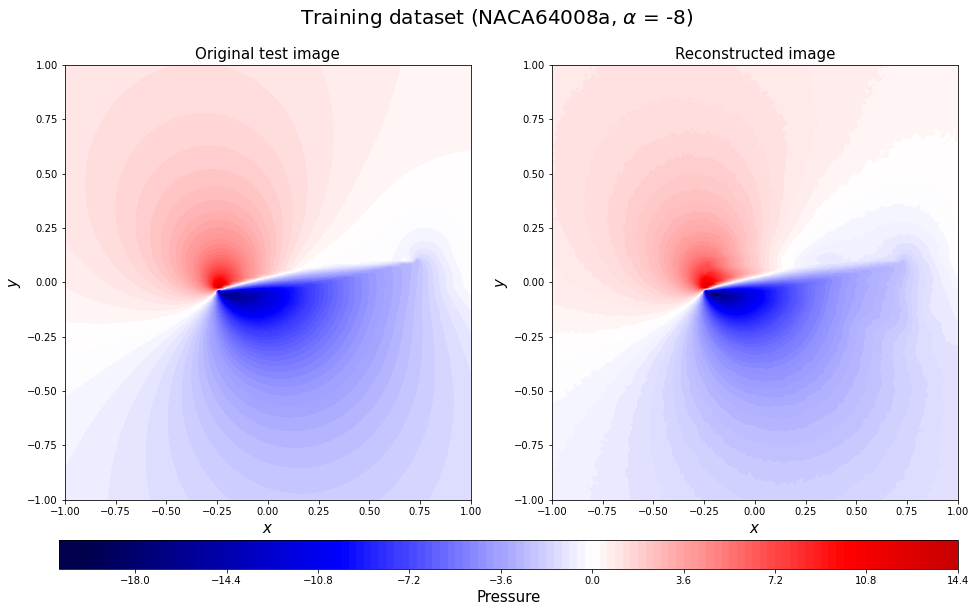

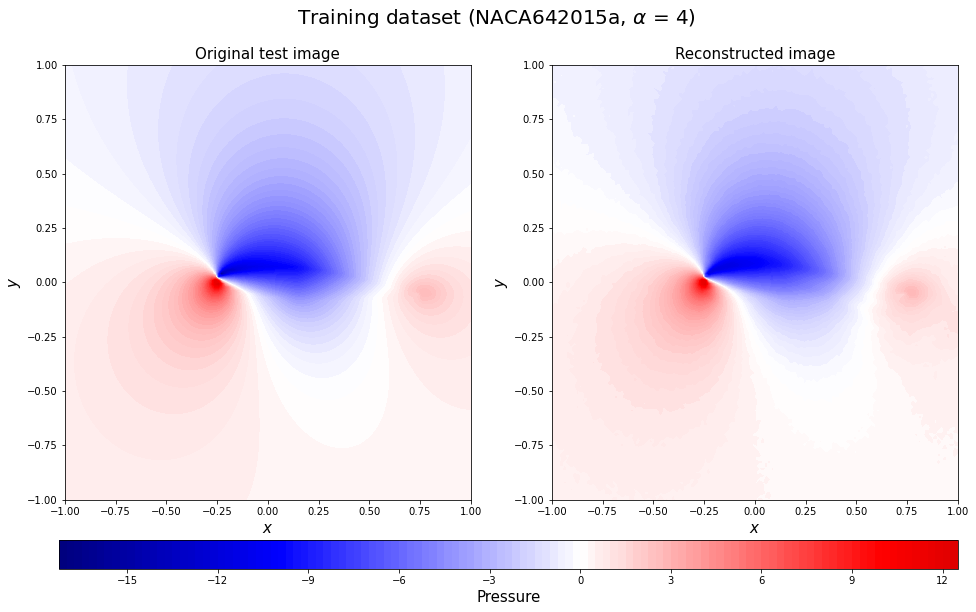

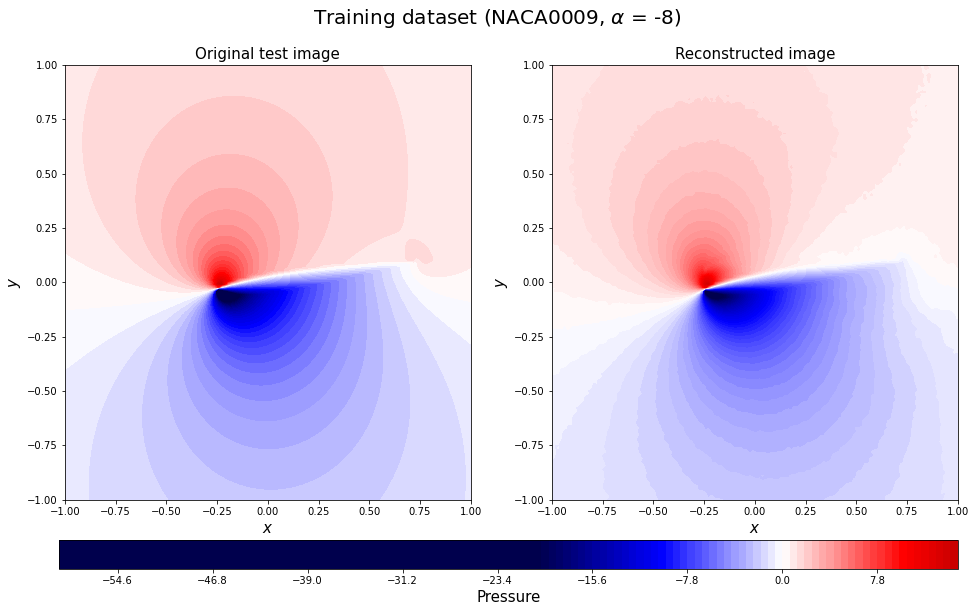

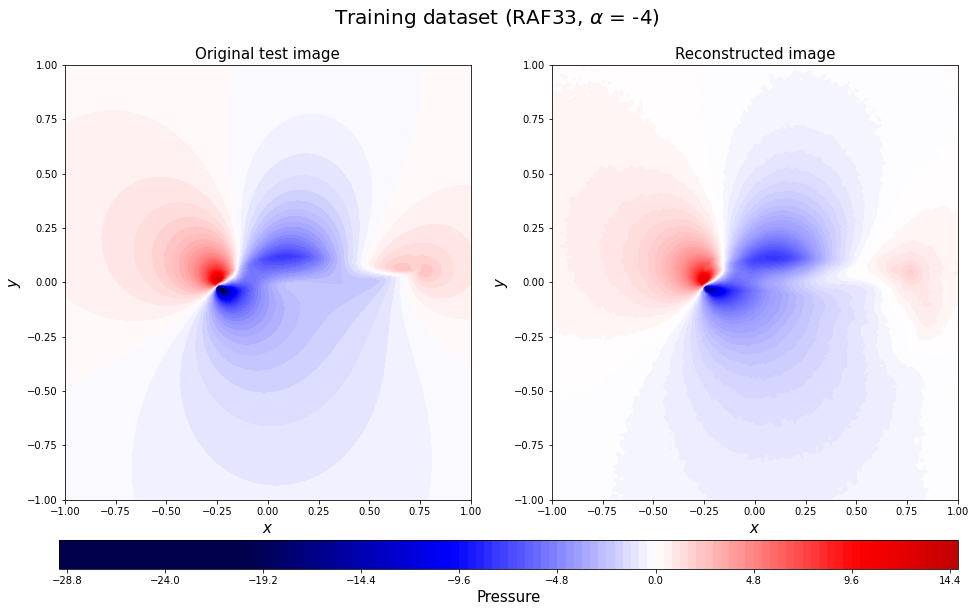

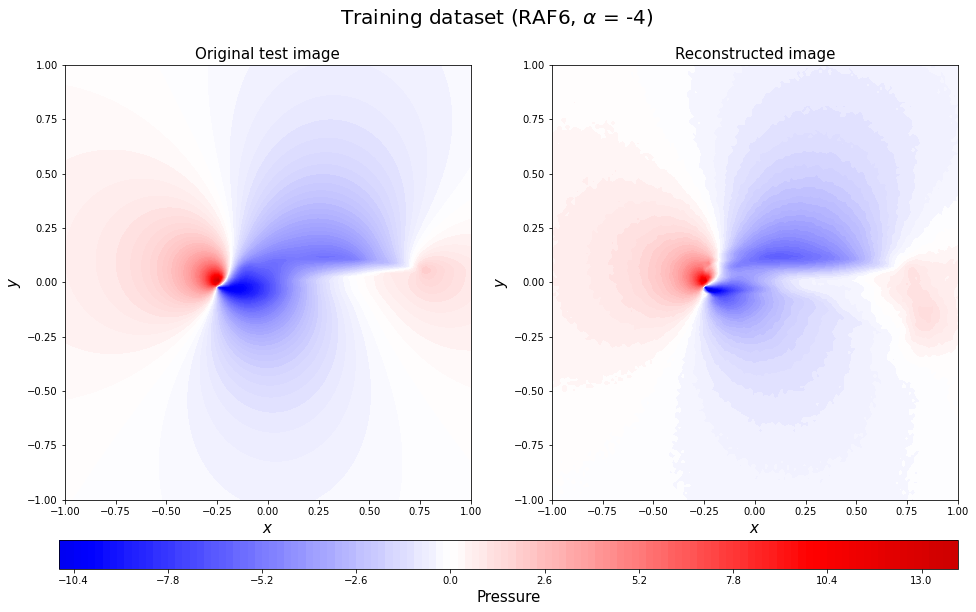

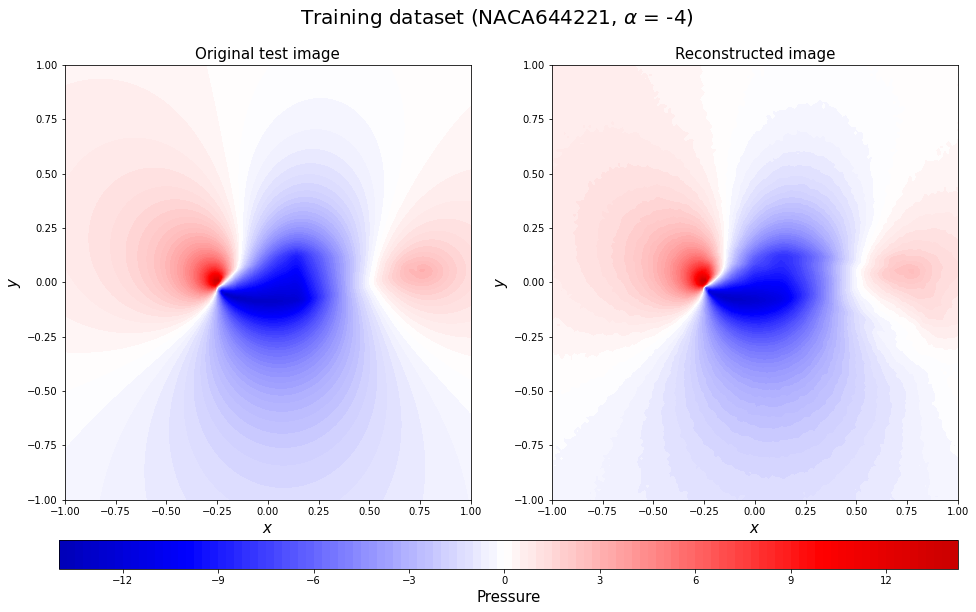

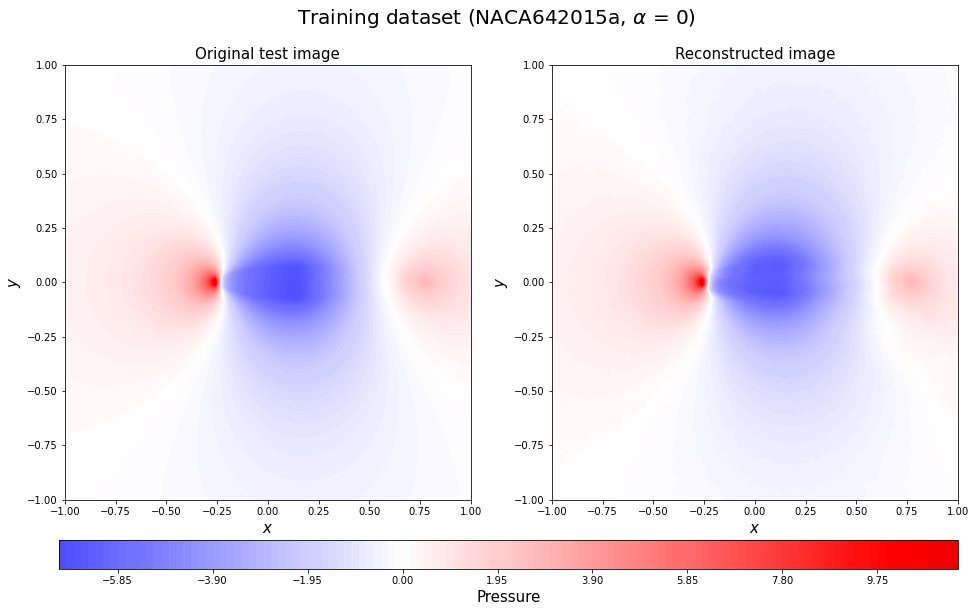

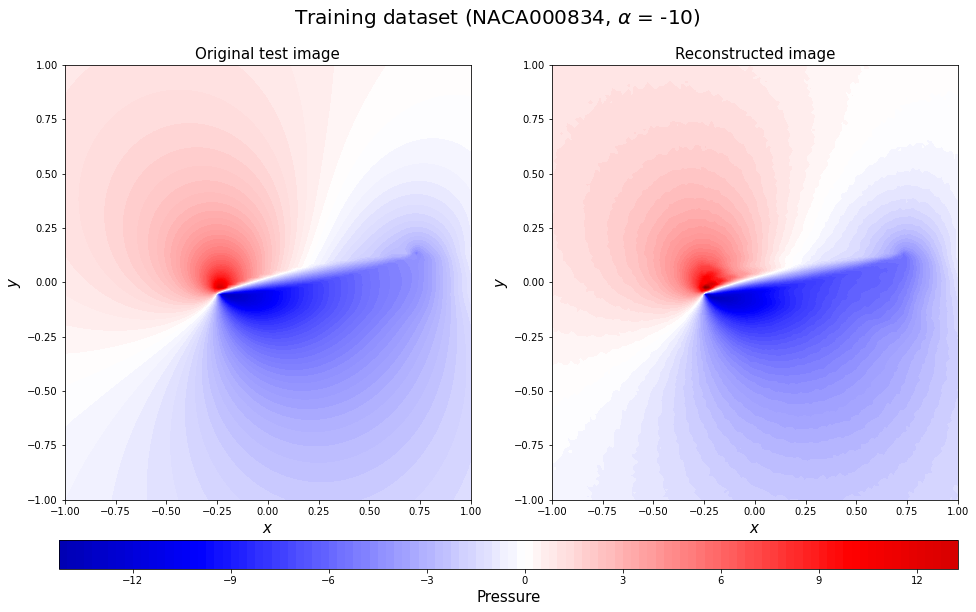

In [66]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*16+c].reshape(n_grid,n_grid)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate,vmin=-20, vmax=20,  levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=-20, vmax=20,  levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Pressure', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*16+c])[3:-2], aa_train[20*16+c]),fontsize=20)
    save_fig_name = "20221107Prediction_AeroCNN-II(training)"+str(np.array2string(geo_train[20*16+c])[3:-2])+str(aa_train[20*16+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

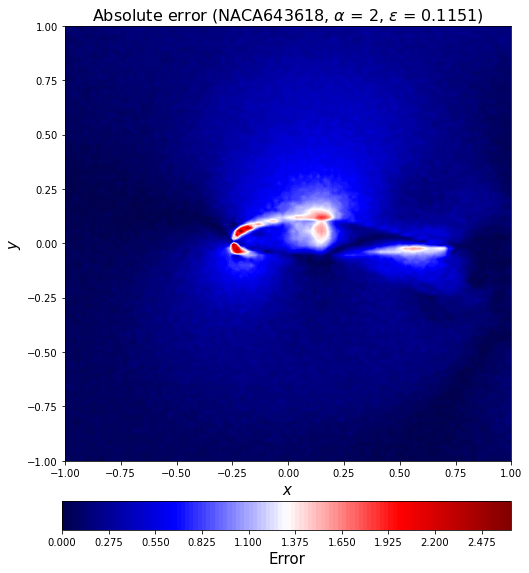

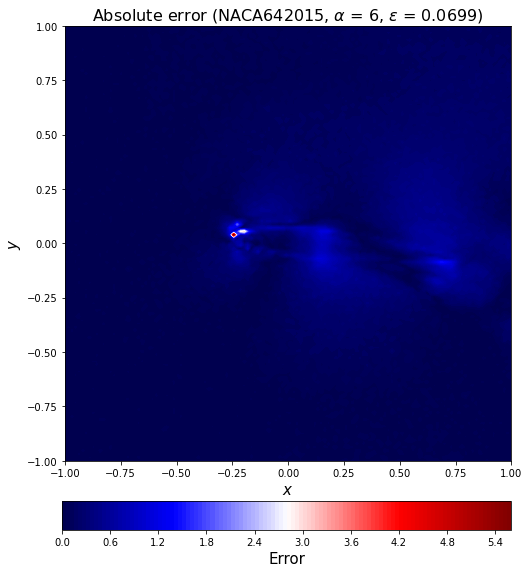

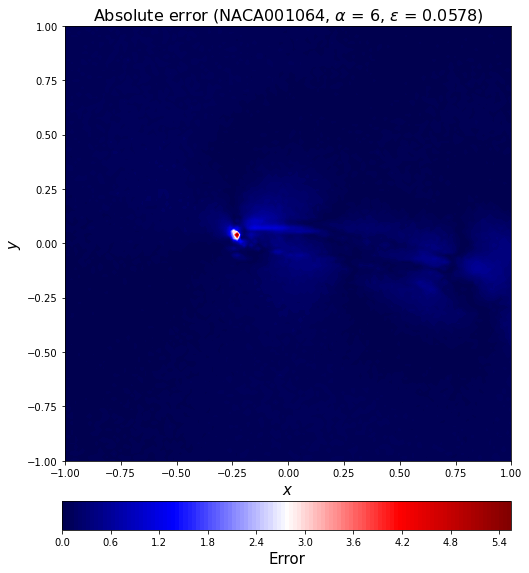

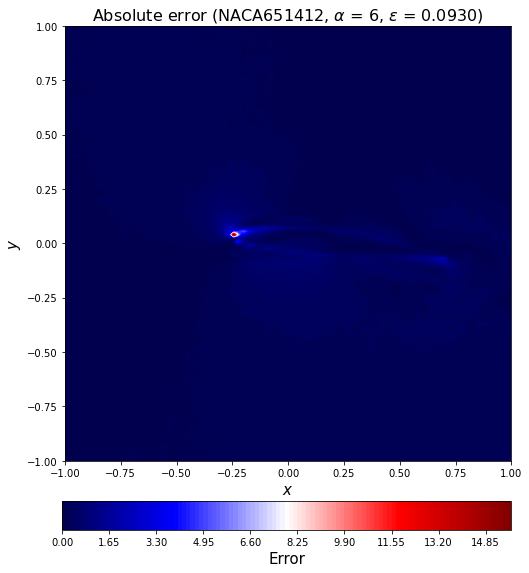

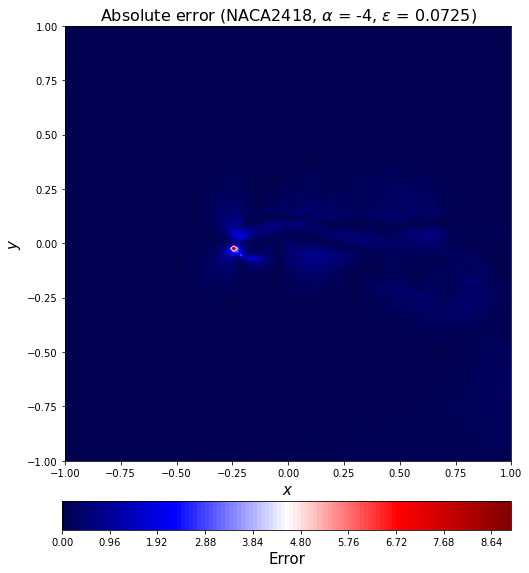

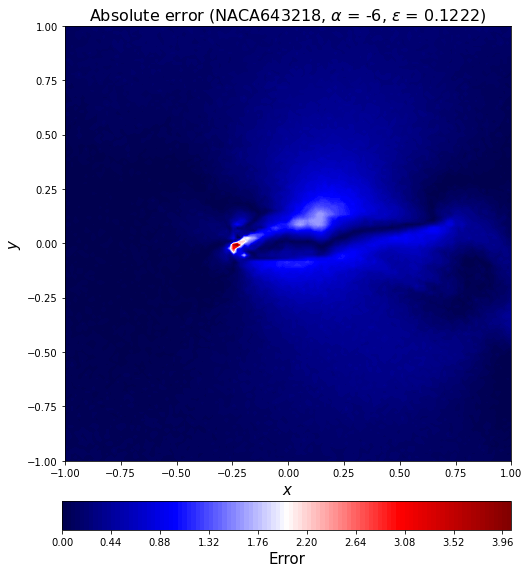

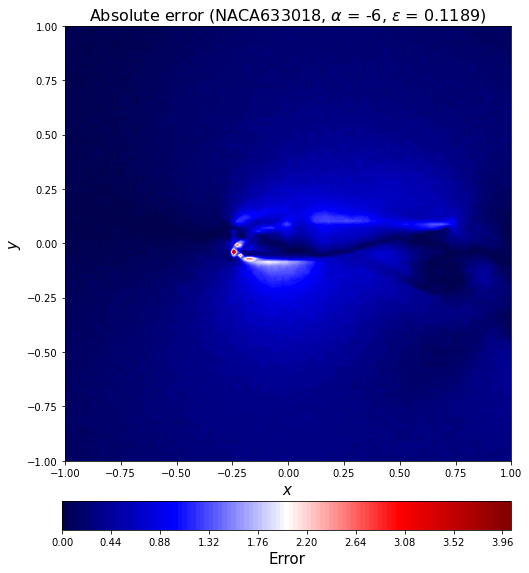

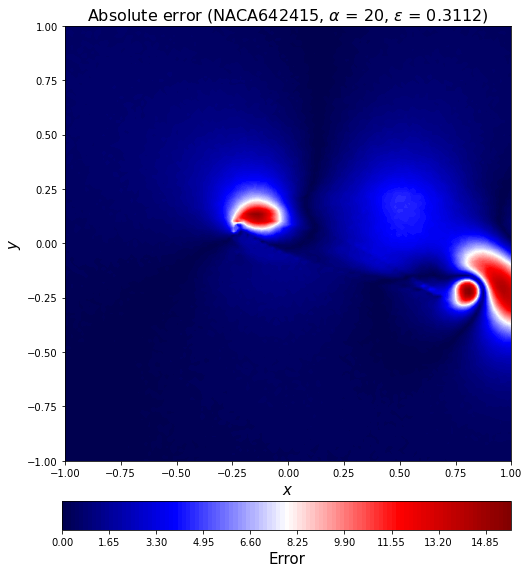

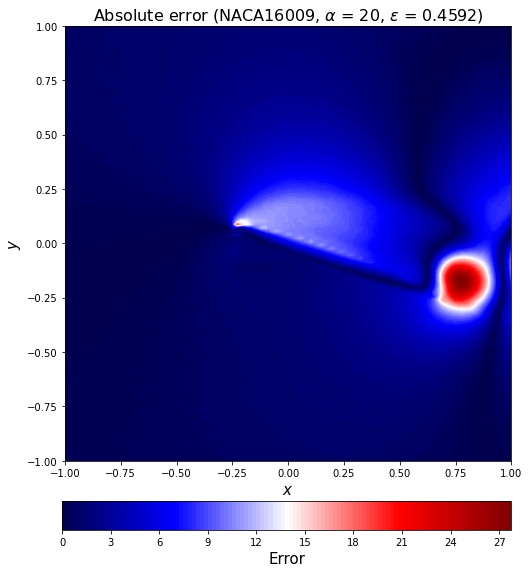

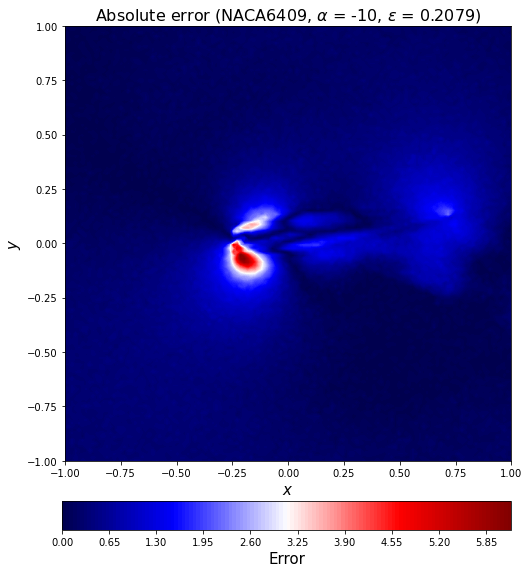

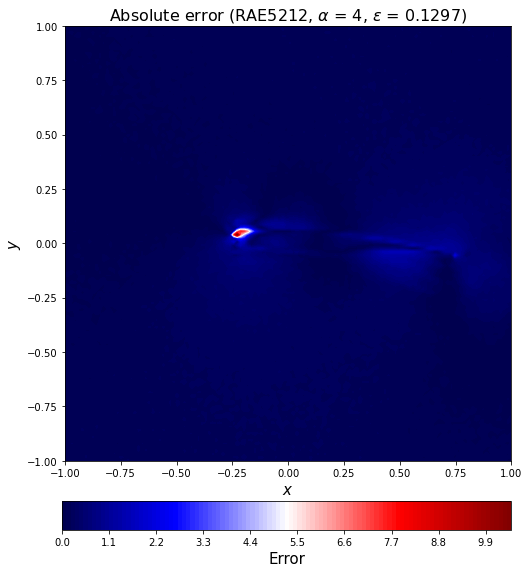

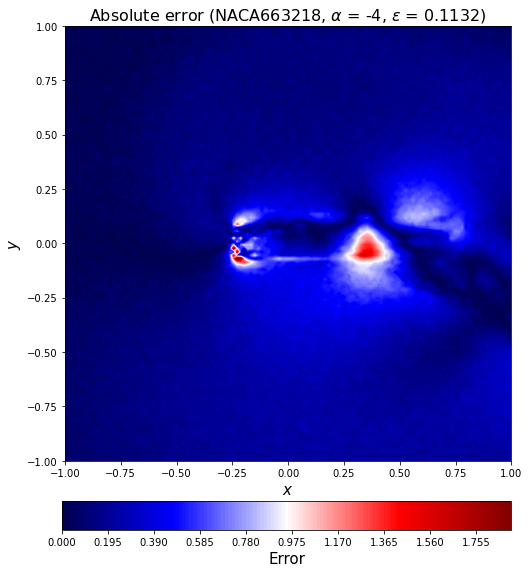

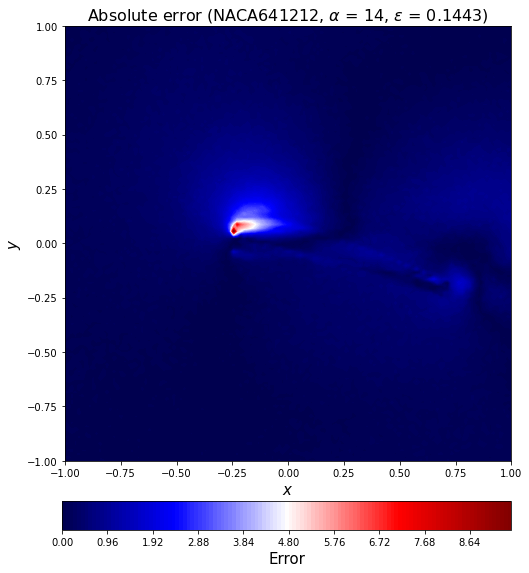

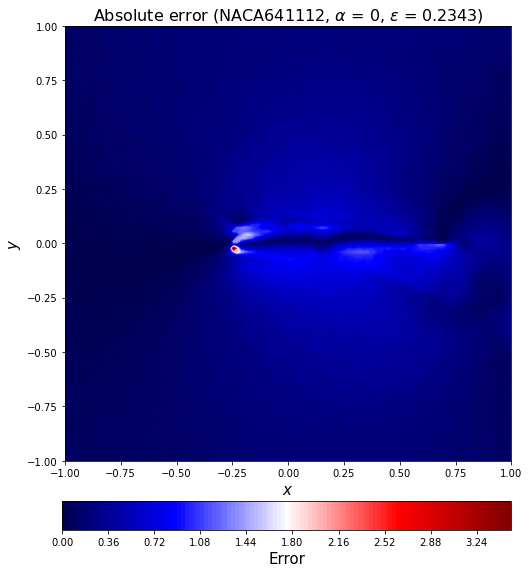

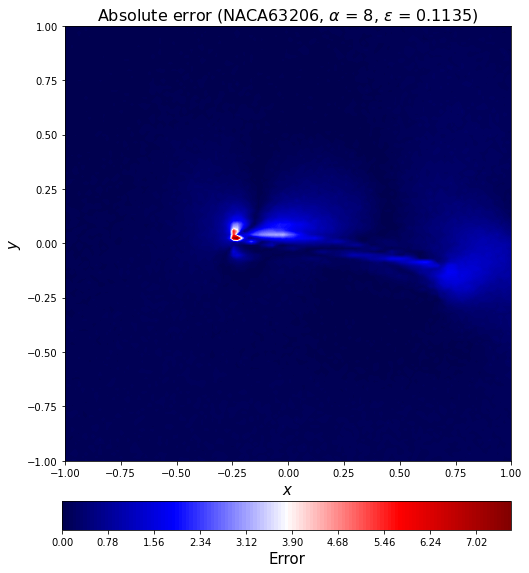

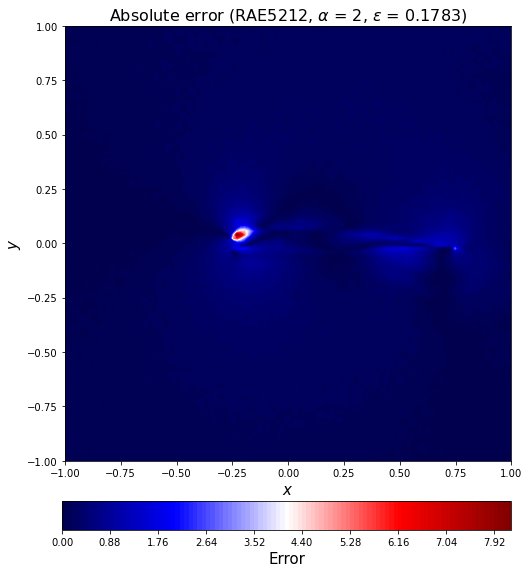

In [67]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[2*16+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*16+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*16+c]), fontsize=16)
    ax5.set_xlabel('$x$', fontsize=15)
    ax5.set_ylabel('$y$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221107PredictionError_AeroCNN-II(test)"+str(np.array2string(geo_test[2*16+c])[3:-2])+str(aa_test[2*16+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

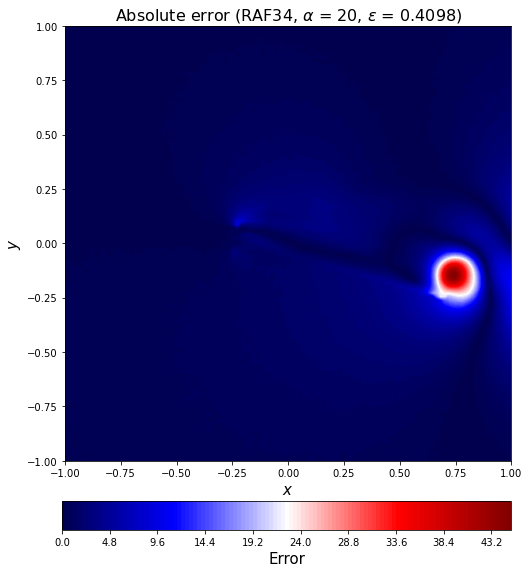

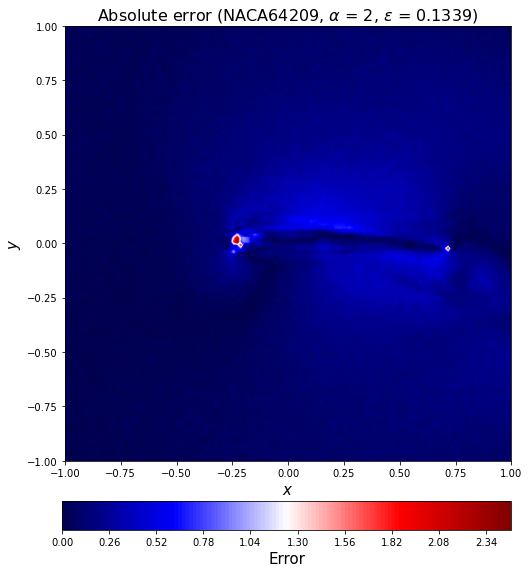

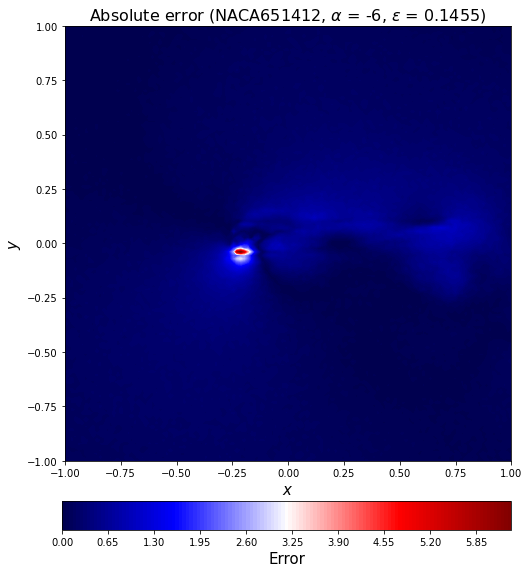

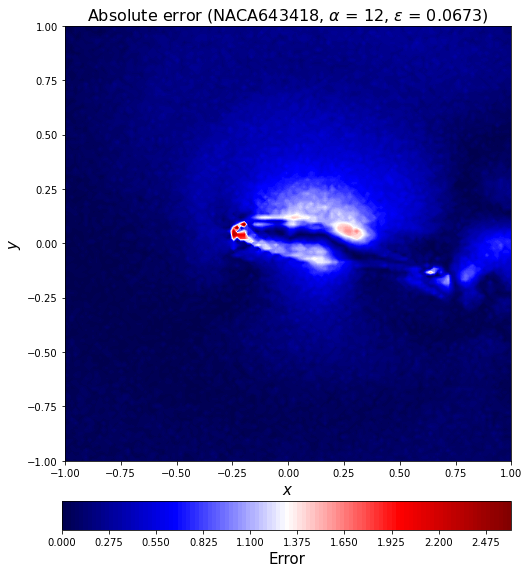

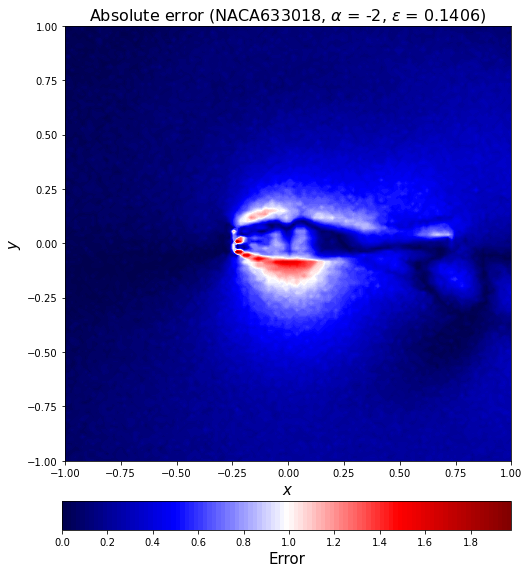

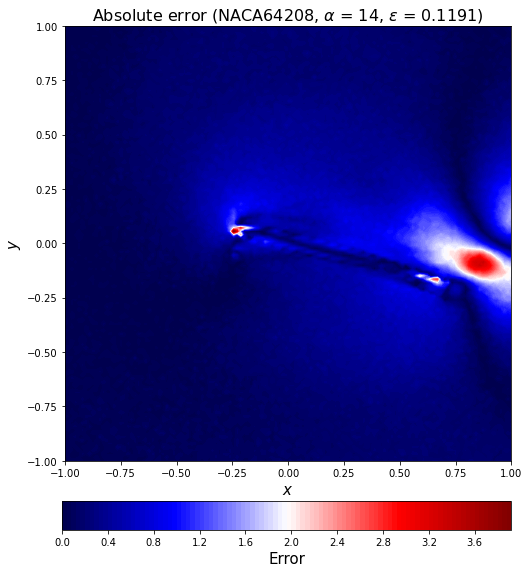

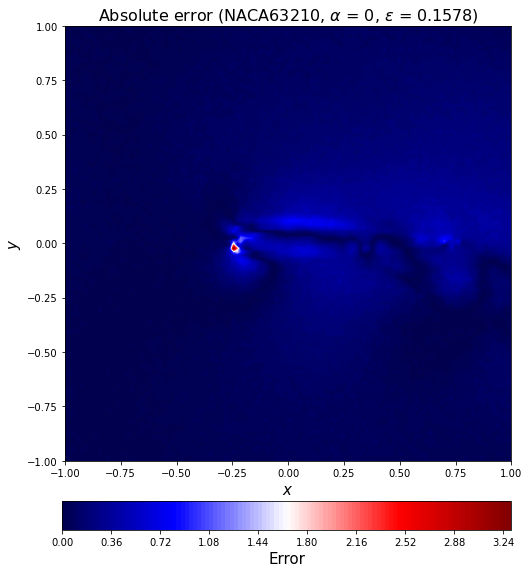

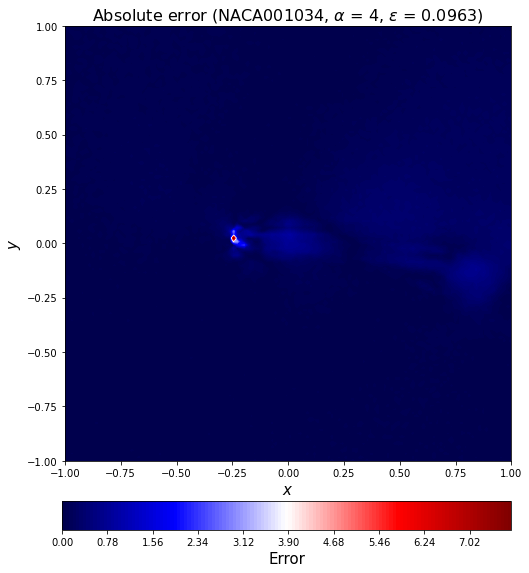

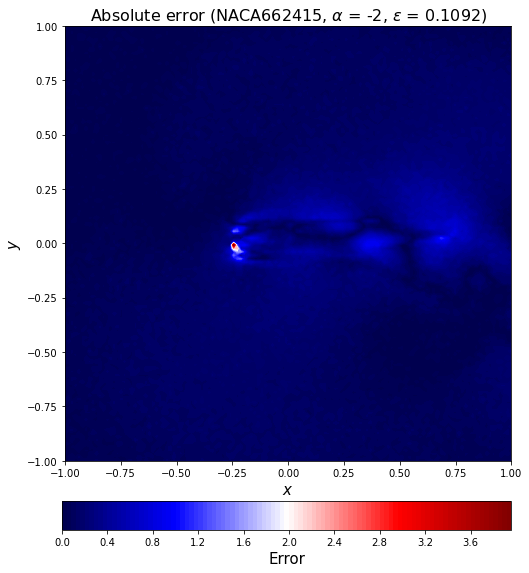

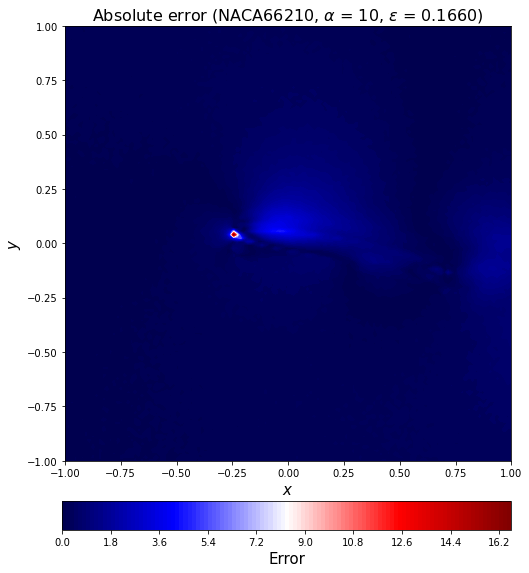

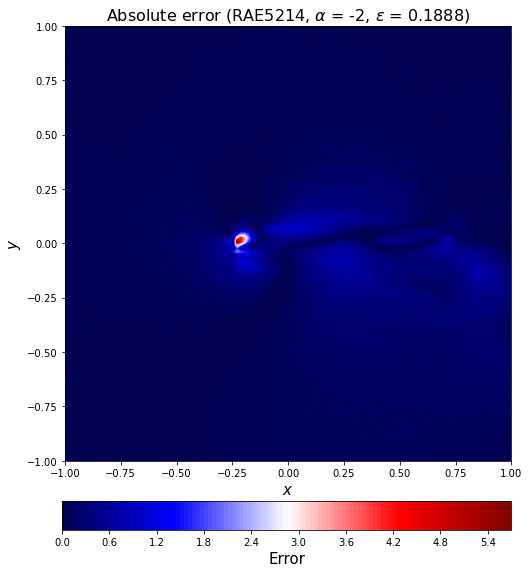

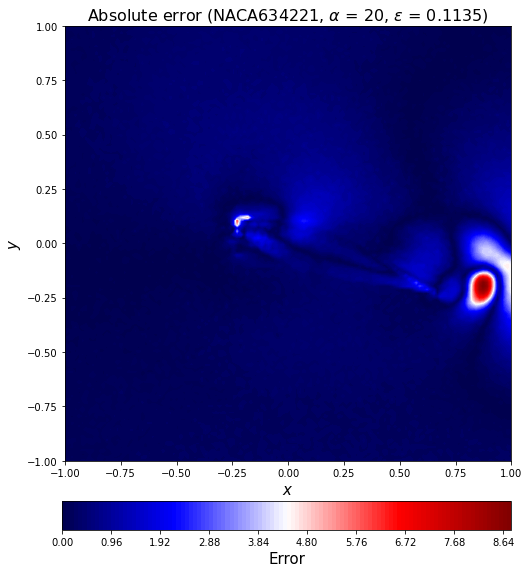

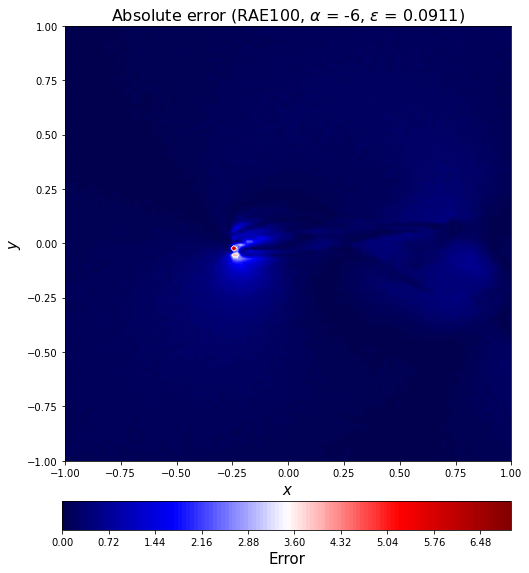

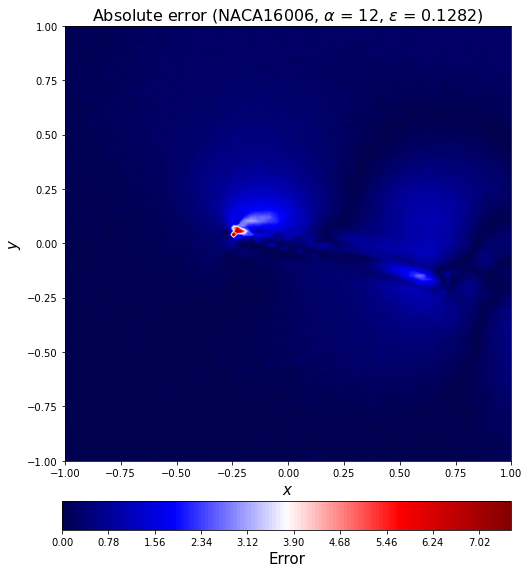

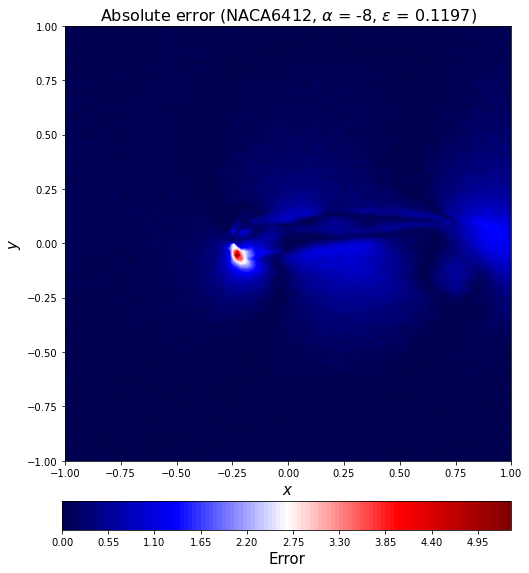

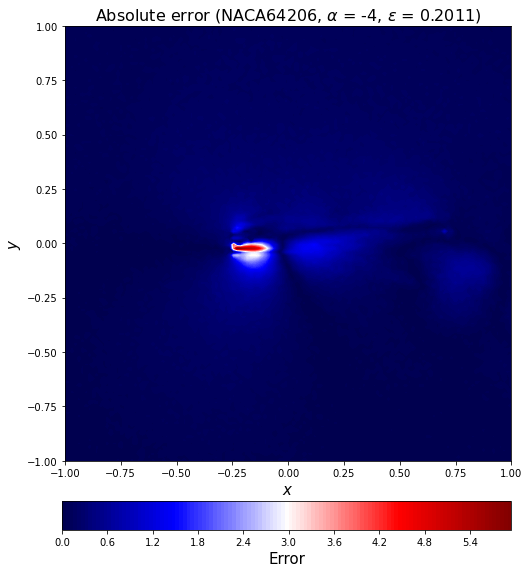

In [68]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$x$', fontsize=15)
    ax5.set_ylabel('$y$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221107PredictionError_AeroCNN-II(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

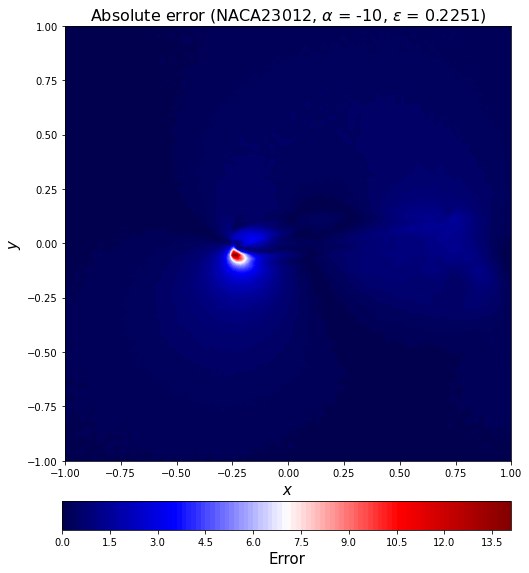

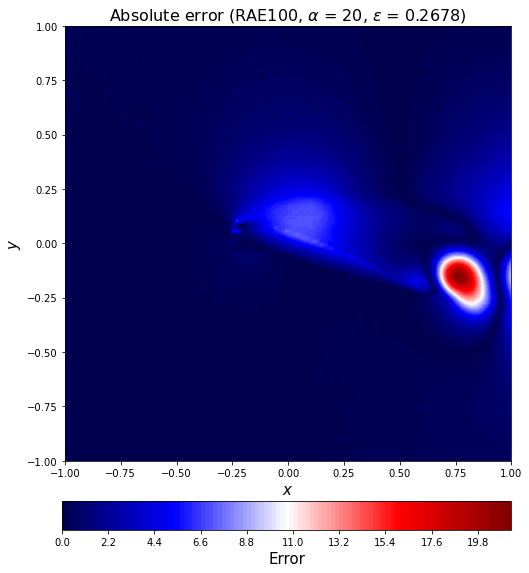

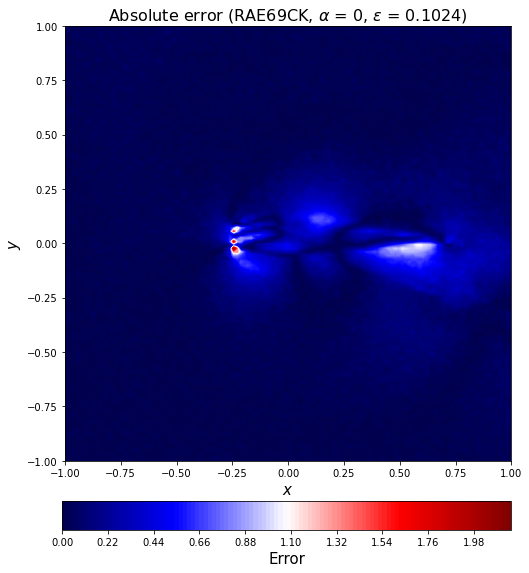

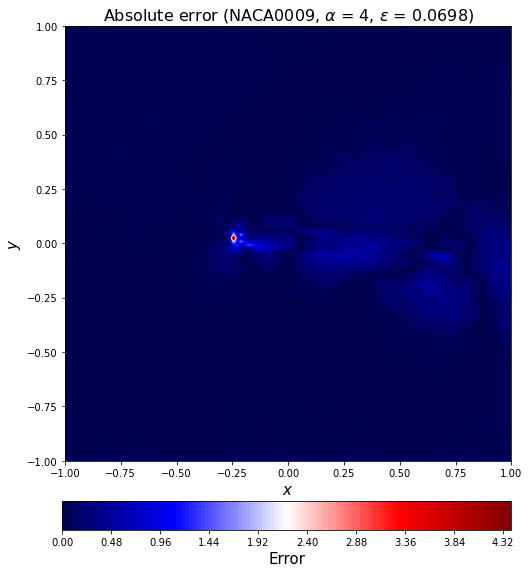

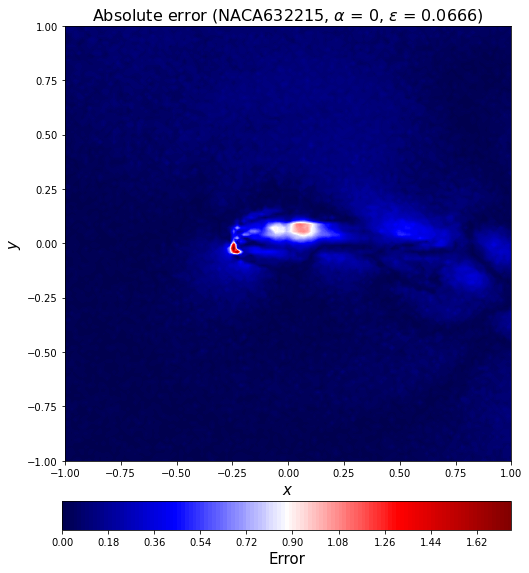

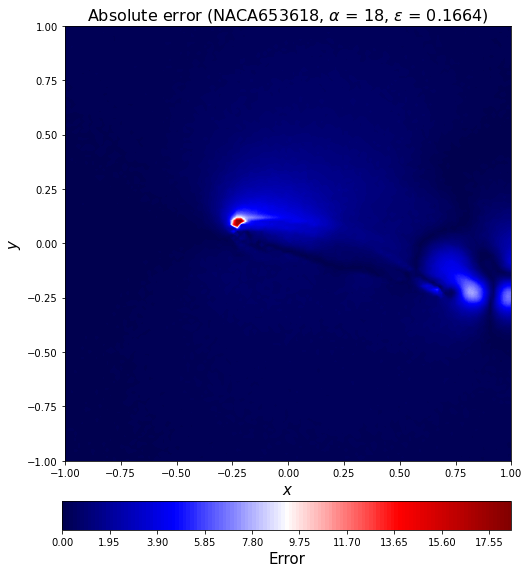

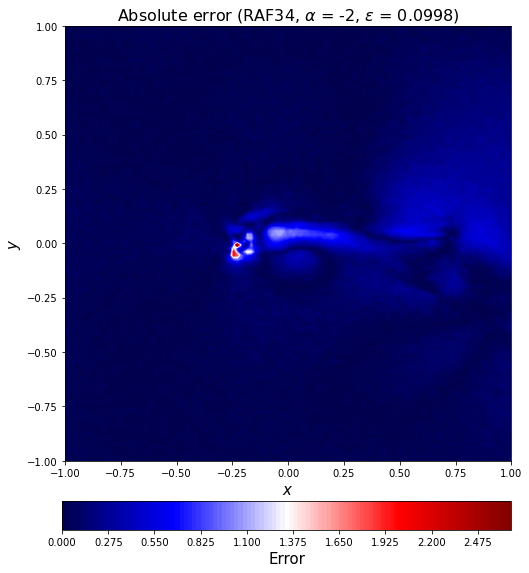

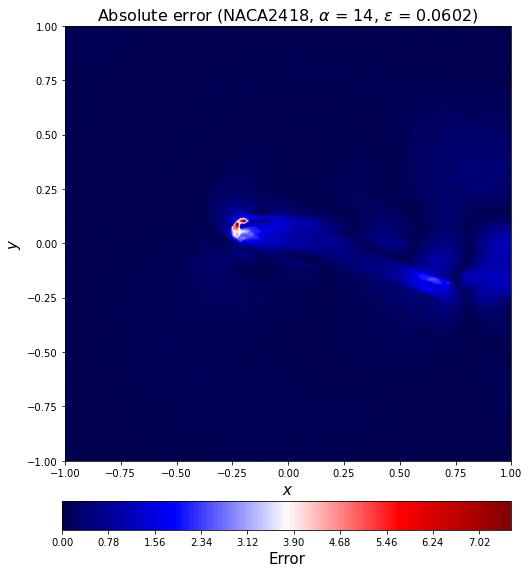

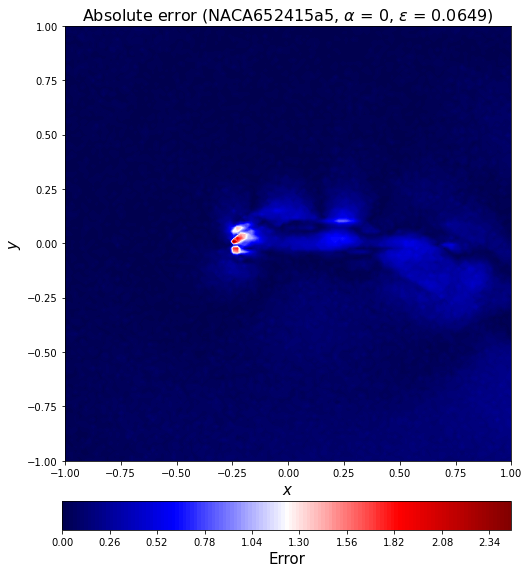

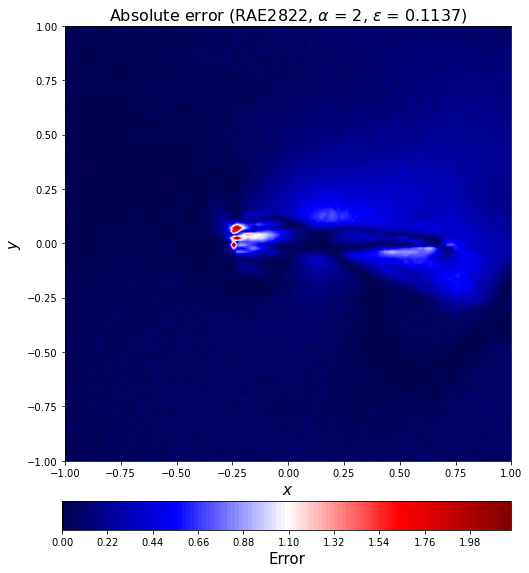

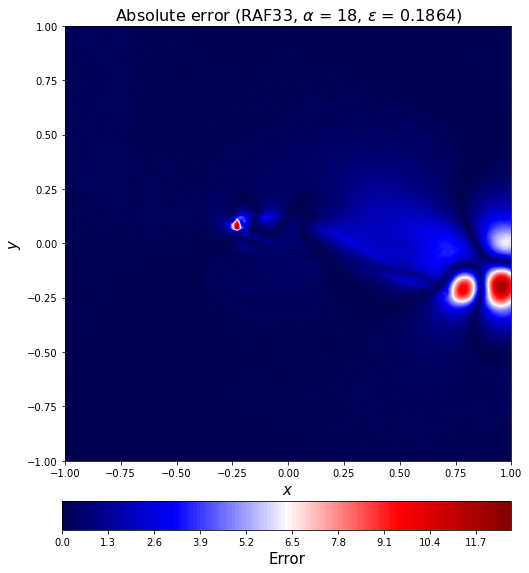

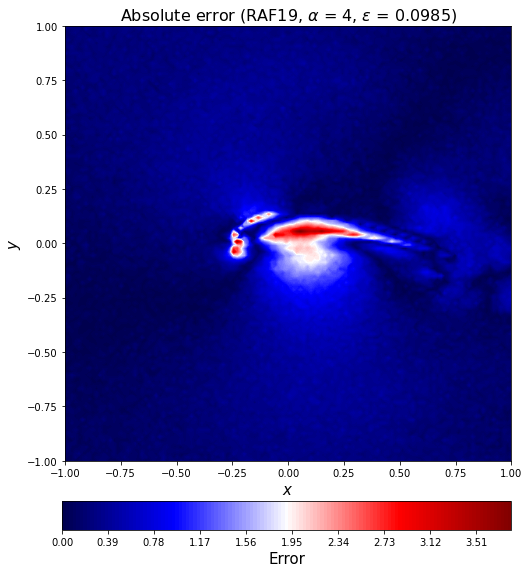

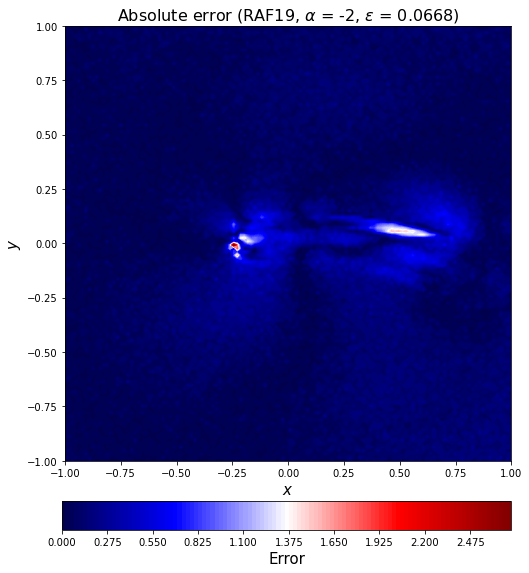

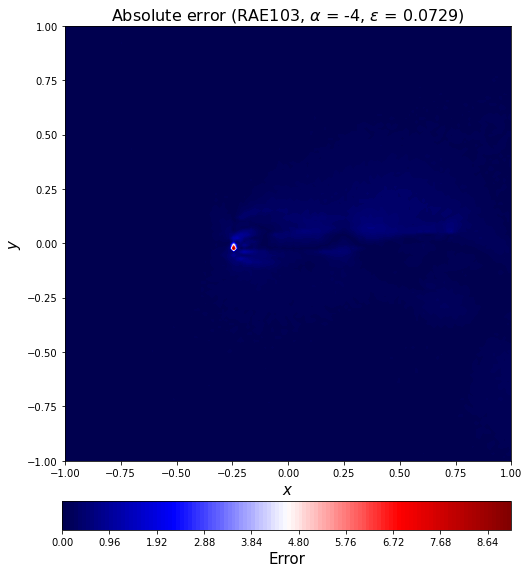

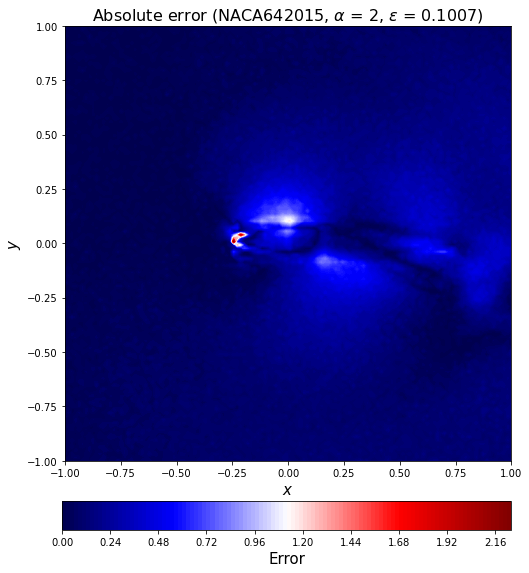

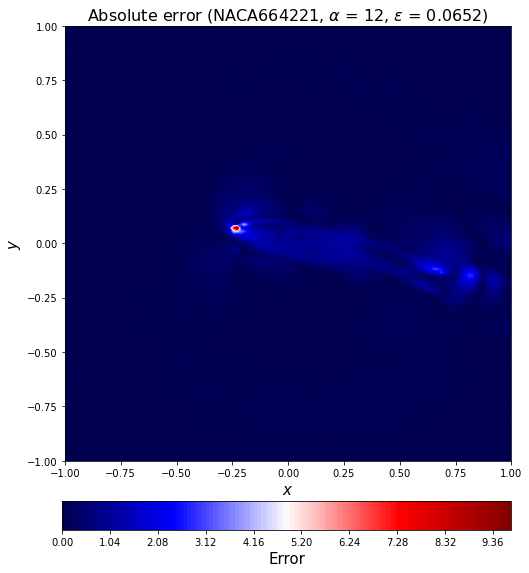

In [69]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$x$', fontsize=15)
    ax5.set_ylabel('$y$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221107PredictionError_AeroCNN-II(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

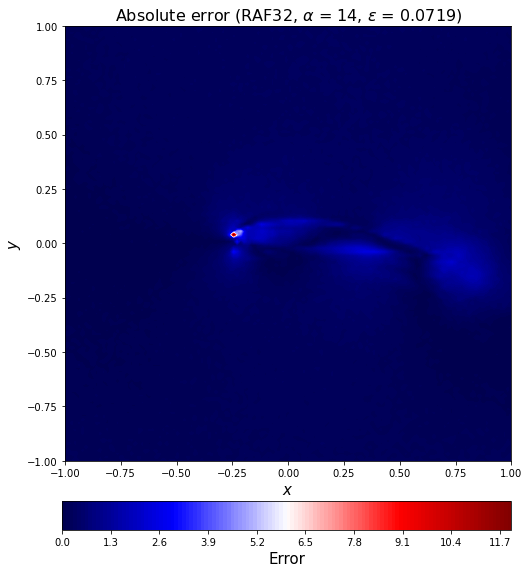

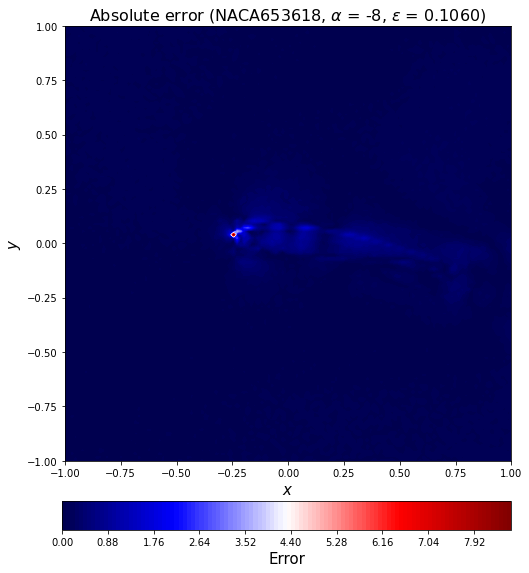

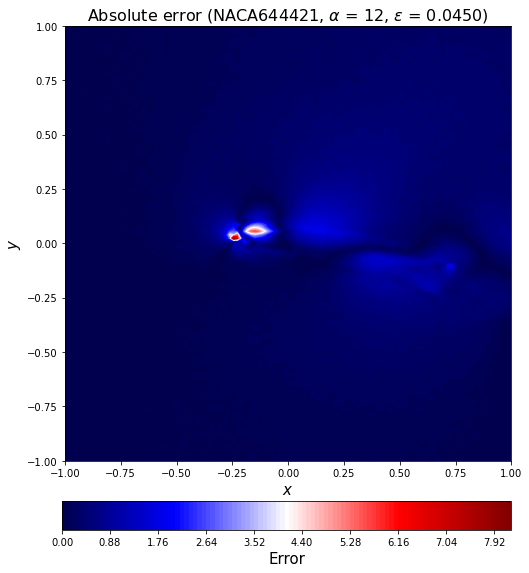

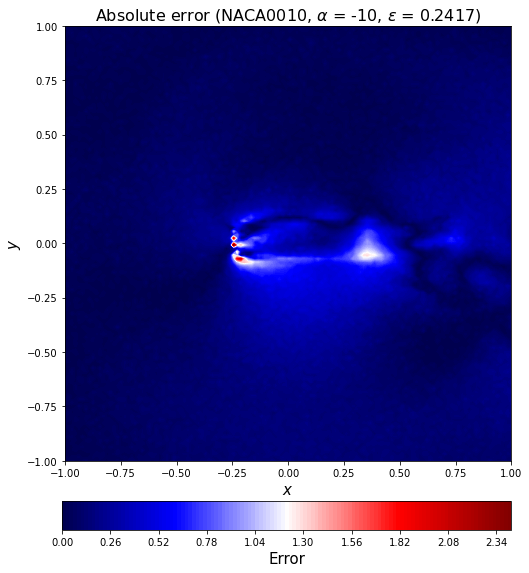

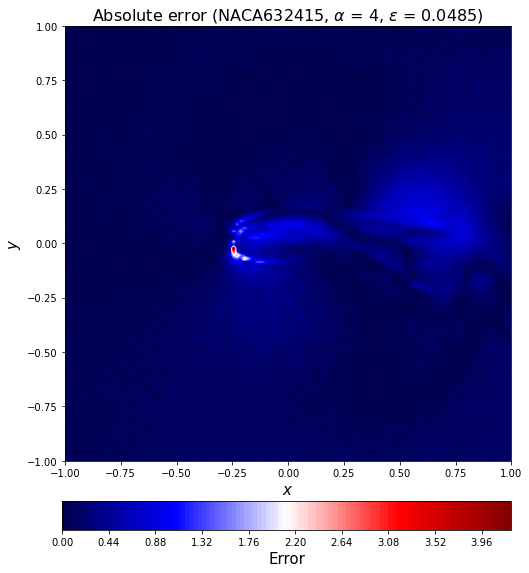

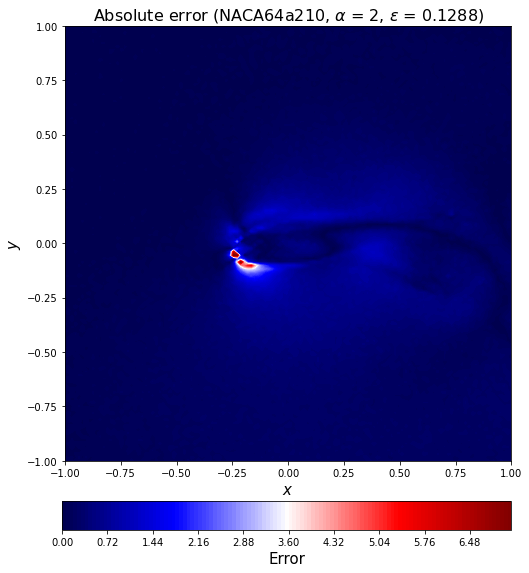

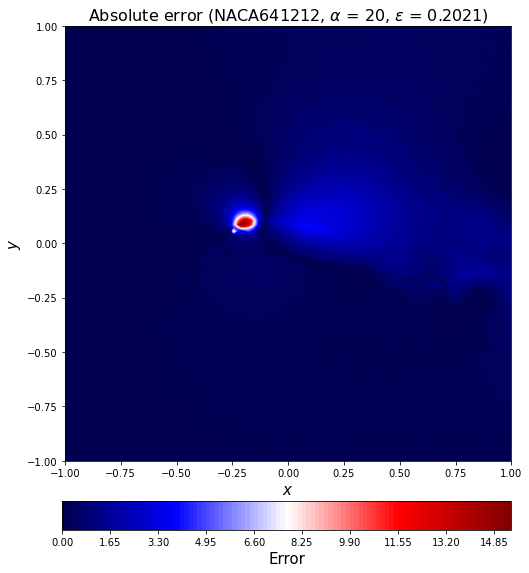

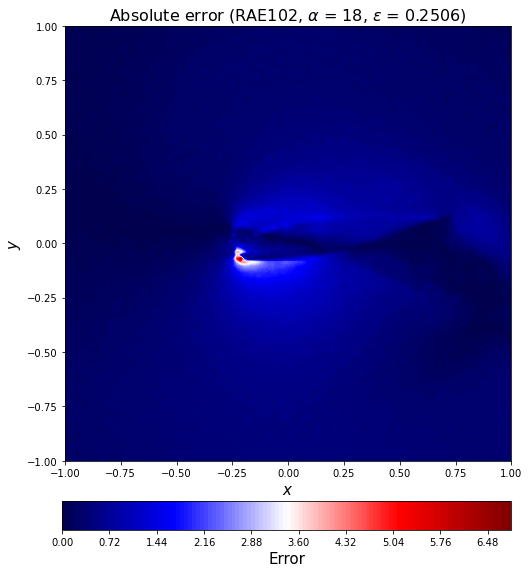

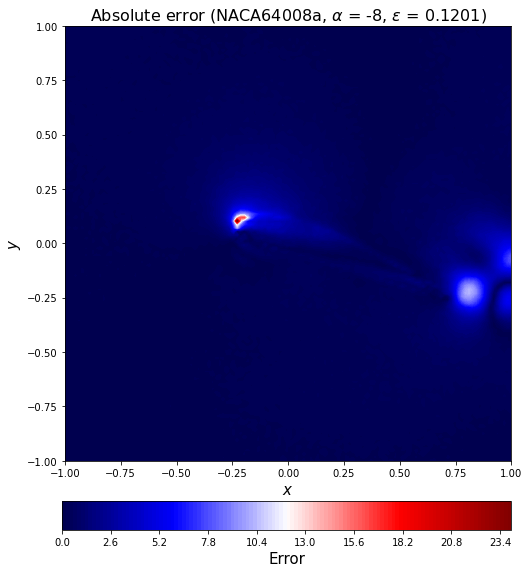

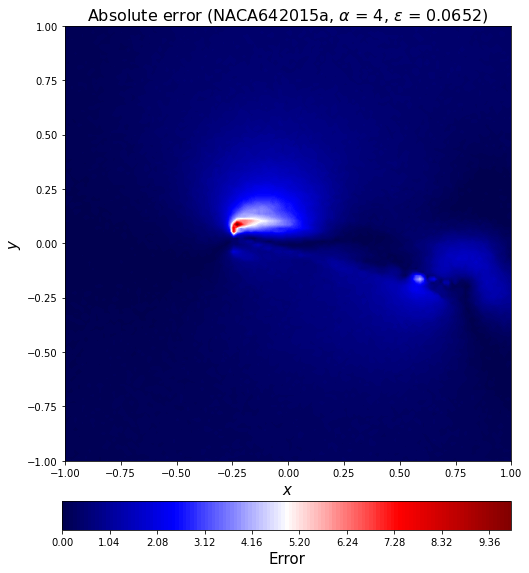

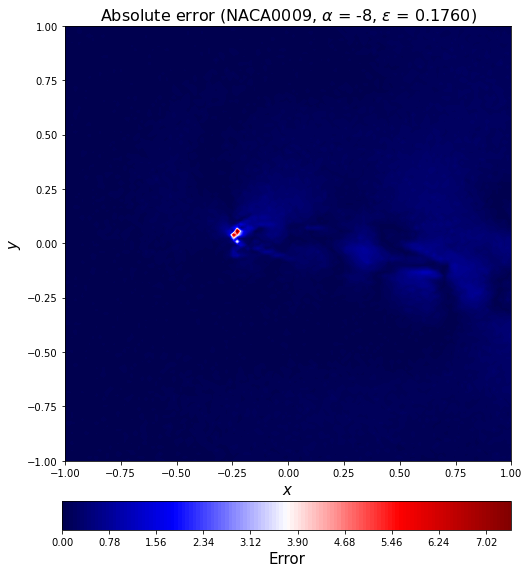

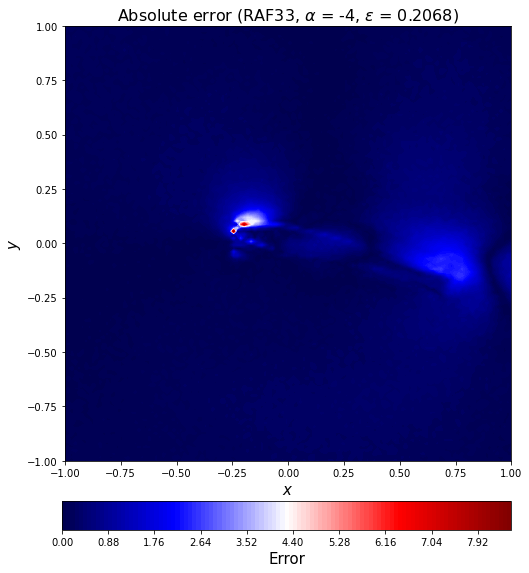

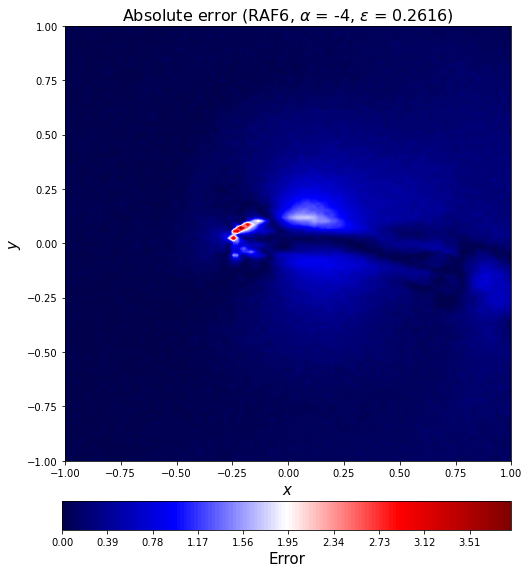

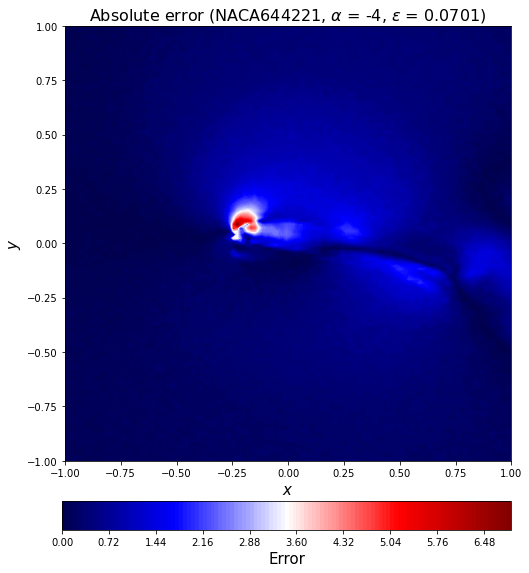

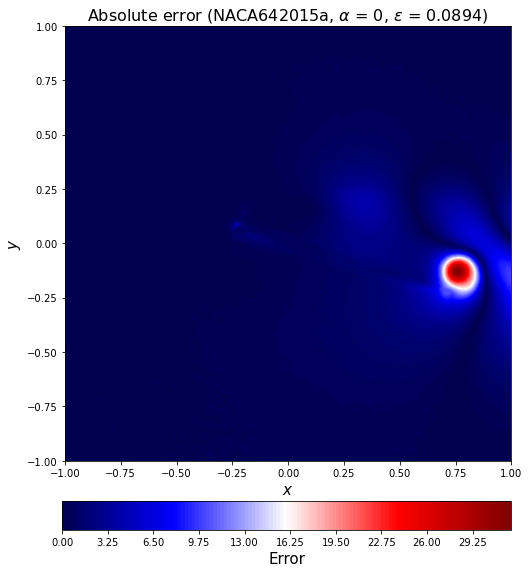

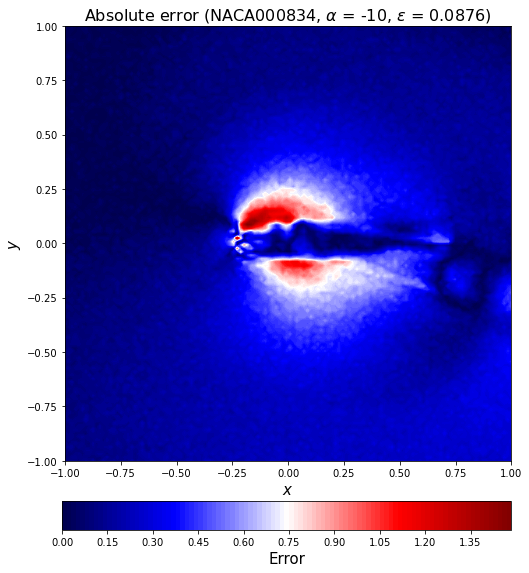

In [70]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[11*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[16*20+c])[3:-2],
                                                                             aa_train[16*20+c], l2_error_train_list[16*20+c]),fontsize=16)
    ax5.set_xlabel('$x$', fontsize=15)
    ax5.set_ylabel('$y$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221107PredictionError_AeroCNN-II(training)"+str(np.array2string(geo_train[16*20+c])[3:-2])+str(aa_train[16*20+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()